## MARBL diagnostics for ocean history files: 

### Case: g.e30_b06p.GW1850MARBL_JRA.TL319_t232_wgx3_hycom1_N75.006


In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import utils
import pandas as pd
import pop_tools
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from xgcm import Grid
xr.set_options(keep_attrs=True);

### Define case

In [2]:
case = 'g.e30_b07.GW1850MARBL_JRA.TL319_t232_wgx3_hycom1_N75.006'
user = 'kristenk'

## Define the year range to examine and get the CESM history files

In [3]:
start_yr = 7
num_years = 2
endyr = start_yr + num_years 

#### first get the 3-D variables

In [4]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 7 !
doing simulation year 8 !


In [5]:
cesm_mon_ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

#### Now grab the 2-D variables

In [6]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.native.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 7 !
doing simulation year 8 !


In [7]:
cesm_mon_ds2 = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

### Keep only the variables we need (use this list for both 2-D and 3-D datasets)

In [8]:
variables2d = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','CaCO3_PROD_zint','POC_FLUX_100m',
             'x_graze_microzoo_zint','x_graze_mesozoo_zint',
            'IFRAC','FG_CO2'] 

variables3d = ['SiO2_PROD','coccoCaCO3','diatC', 'coccoC','spC','diazC',
               'SALT','diatN', 'coccoN','spN','diazN',
             'PO4','Fe','NO3','SiO3','O2','ALK','photoC_TOT_zint_100m',
            'microzooC','mesozooC','diaz_Nfix',
            'spChl','diatChl','diazChl','coccoChl','so','DIC','ts'] 


coords = {'x':'yh','y':'xh'}

In [9]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables3d + list(coords.values())
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keepthese])

In [10]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables2d + list(coords.values())
cesm_mon_ds2 = cesm_mon_ds2.drop([v for v in cesm_mon_ds2.variables if v not in keepthese])

## Get the grid data for MOM6

In [11]:
ds_grid = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e23b16.TL319_t232.GIAFMARBL.001.mom6.h.static.nc')
ds_grid2 = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e30_b06.GJRAv4.TL319_t232_wgx3_hycom1_N75.2025.081.mom6.h.ocean_geometry.nc')

In [12]:
lons = ds_grid.geolon
lats = ds_grid.geolat
area = ds_grid.areacello #m2
depths = cesm_mon_ds.z_l

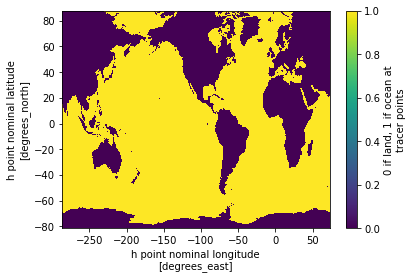

In [13]:
ds_grid.wet.plot()

#### Make my own dz variable

In [14]:
dz = np.zeros([34])

i = 0

for int in cesm_mon_ds.z_i.values[1:35]:
    
    level_up = cesm_mon_ds.z_i.values[i]
    #print(level_up,int)
    dz[i] = int - level_up

    i = i + 1

dz = xr.DataArray(dz,dims=('z_l'))

### spin up a bit of dask

In [15]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='P93300070',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [16]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

<Client: 'tcp://128.117.208.181:44501' processes=0 threads=0, memory=0 B>

### Make the annual mean

In [17]:
cesm_ann_ds = cesm_mon_ds.mean(dim='time', keep_attrs=True).compute()

In [18]:
cesm_ann_ds2 = cesm_mon_ds2.mean(dim='time', keep_attrs=True).compute()

### Turn the monthly ds into a climatology

In [19]:
cesm_mon_ds = cesm_mon_ds.groupby('time.month').mean('time', keep_attrs=True)

In [20]:
cesm_mon_ds2 = cesm_mon_ds2.groupby('time.month').mean('time', keep_attrs=True)

### Make Global BGC metrics table

In [21]:
ds_glb = xr.Dataset()
mmols_to_PgCyr = 1e-3 * 12. * 1e-15 * 365. * 86400.

variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]
variables = variables + ['CaCO3_PROD_zint','POC_FLUX_100m','FG_CO2']
variables = variables + [f'x_graze_{zoo}_zint' for zoo in ['microzoo', 'mesozoo']]

for v in variables:
    ds_glb[v] = ((cesm_ann_ds2[v] * area).sum(dim=('xh', 'yh'))).compute() #mmol/m
    ds_glb[v].attrs = cesm_ann_ds2[v].attrs

    ds_glb[v] = ds_glb[v] * mmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

############ SiO2 production
tmp = (cesm_ann_ds.SiO2_PROD * dz).sum(dim='z_l') ## depth integral, units in mmol/m2/s
tmp = tmp * area ## mmol/s
tmp = tmp * 86400. * 365 * 0.001 ## mol/yr 
tmp = tmp.sum(dim=('xh','yh')) * 1.e-12 #Tmol/yr
ds_glb['SiO2_PROD'] = tmp.compute()
ds_glb['SiO2_PROD'].attrs['units'] = 'Tmol Si yr$^{-1}$'

######### diatom and zooplankton percents of total NPP
ds_glb['diatNPPpercent'] = ds_glb.photoC_diat_zint / ds_glb.photoC_TOT_zint * 100.
ds_glb['diatNPPpercent'].attrs['units'] = '%'

ds_glb['zooprodNPPpercent'] = (ds_glb['x_graze_mesozoo_zint'] + ds_glb['x_graze_microzoo_zint'])/ds_glb['photoC_TOT_zint'] * 100.
ds_glb['zooprodNPPpercent'].attrs['units'] = '%'

######## Nitrogen fixation
area_depth = area.where(cesm_ann_ds.ALK > 0)
tmp = (cesm_ann_ds['diaz_Nfix'] * area_depth).sum(dim=('xh', 'yh')).compute() #mmol/m
ds_glb['diaz_Nfix'] = (tmp * dz).sum(dim='z_l') #mmol
ds_glb['diaz_Nfix'] = ds_glb['diaz_Nfix'] * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr
ds_glb['diaz_Nfix'].attrs['units'] = 'Tg N yr$^{-1}$'

########### total mesozoo and microzoo biomass
for zoo in ['microzooC','mesozooC']:
    tmp = ((cesm_ann_ds[zoo] * area_depth).sum(dim=('xh', 'yh'))).compute() #mmol/m
    tmp = tmp * dz #mmol
    tmp = tmp.sum(dim='z_l').values * 0.001 * 1.e-15 * 12.011 #Pg C
    ds_glb[zoo] = tmp
    ds_glb[zoo].attrs['units'] = 'Pg C'


ds_glb = ds_glb.compute()

In [22]:
df = pd.DataFrame(columns=['Metric','unit','CESM','Obs','Reference'])


df.loc[0] = ['NPP',ds_glb.photoC_TOT_zint.attrs['units'],np.round(ds_glb.photoC_TOT_zint.values, 2),'45 to 55','Behrenfeld & Falkowski 1997; Carr et al., 2006']
df.loc[1] = ['POC export 100m',ds_glb.POC_FLUX_100m.attrs['units'],np.round(ds_glb.POC_FLUX_100m.values, 2),'4 to 12','DeVries & Weber, 2017']
df.loc[2] = ['air-sea CO2 flux',ds_glb.FG_CO2.attrs['units'],np.round(ds_glb.FG_CO2.values, 2),'around 0','(for preindustrial run; negative = into ocean)']
df.loc[3] = ['%NPP by diatoms',ds_glb.diatNPPpercent.attrs['units'],np.round(ds_glb.diatNPPpercent.values, 2),'40%','Nelson et al., 1995']
df.loc[4] = ['Silicification',ds_glb.SiO2_PROD.attrs['units'],np.round(ds_glb.SiO2_PROD.values, 2),'100 to 190','Nelson et al., 1995; Holzer et al., 2014']
df.loc[5] = ['Calcification',ds_glb.CaCO3_PROD_zint.attrs['units'],np.round(ds_glb.CaCO3_PROD_zint.values, 2),'0.7 to 4.7','Liang et al., 2023; Ziveri et al., 2023 and refs therein']
df.loc[6] = ['Nitrogen fixation',ds_glb.diaz_Nfix.attrs['units'],np.round(ds_glb.diaz_Nfix.values, 2),'125.6 and 222.9','Wang et al., 2019']
df.loc[7] = ['Microzooplankton biomass',ds_glb.microzooC.attrs['units'],np.round(ds_glb.microzooC.values, 2),'0.24','Buitenhuis et al., 2010']
df.loc[8] = ['Mesozooplankton biomass',ds_glb.mesozooC.attrs['units'],np.round(ds_glb.mesozooC.values, 2),'0.16 to 0.19','Buitenhuis et al., 2006; Moriarty & OBrien, 2013']
df.loc[9] = ['Zoo prod % of NPP',ds_glb.zooprodNPPpercent.attrs['units'],np.round(ds_glb.zooprodNPPpercent.values, 2),'at least 21%','Landry and Calbet, 2004']
df

Metric               unit    CESM              Obs  \
0                       NPP     Pg C yr$^{-1}$   43.33         45 to 55   
1           POC export 100m     Pg C yr$^{-1}$    5.75          4 to 12   
2          air-sea CO2 flux     Pg C yr$^{-1}$   -0.35         around 0   
3           %NPP by diatoms                  %   34.50              40%   
4            Silicification  Tmol Si yr$^{-1}$  120.47       100 to 190   
5             Calcification     Pg C yr$^{-1}$    1.28       0.7 to 4.7   
6         Nitrogen fixation     Tg N yr$^{-1}$  140.24  125.6 and 222.9   
7  Microzooplankton biomass               Pg C    0.22             0.24   
8   Mesozooplankton biomass               Pg C    0.30     0.16 to 0.19   
9         Zoo prod % of NPP                  %   23.37     at least 21%   

                                           Reference  
0     Behrenfeld & Falkowski 1997; Carr et al., 2006  
1                              DeVries & Weber, 2017  
2     (for preindustrial run; negative = into ocean)  
3                                Nelson et al., 1995  
4           Nelson et al., 1995; Holzer et al., 2014  
5  Liang et al., 2023; Ziveri et al., 2023 and re...  
6                                  Wang et al., 2019  
7                            Buitenhuis et al., 2010  
8   Buitenhuis et al., 2006; Moriarty & OBrien, 2013  
9                            Landry and Calbet, 2004

## Compare macronutrients to World Ocean Atlas 2018

In [23]:
depths = cesm_mon_ds.z_l

In [24]:
ds_woa = xr.open_dataset('/glade/work/kristenk/WOA_data/regrid_MOM6_2_3/WOA_nuts_O2_mom6grid.nc')

### convert WOA data from µmol/kg to mmol/m3

In [25]:
ds_woa['n_an'] = ds_woa['n_an'] * 1.026
ds_woa['n_an'].attrs['units'] = 'mmol/m3'
ds_woa['p_an'] = ds_woa['p_an'] * 1.026
ds_woa['p_an'].attrs['units'] = 'mmol/m3'
ds_woa['o_an'] = ds_woa['o_an'] * 1.026
ds_woa['o_an'].attrs['units'] = 'mmol/m3'
ds_woa['i_an'] = ds_woa['i_an'] * 1.026
ds_woa['i_an'].attrs['units'] = 'mmol/m3'

In [26]:
NO3_diff = cesm_ann_ds.NO3 - ds_woa.n_an
PO4_diff = cesm_ann_ds.PO4 - ds_woa.p_an
SiO3_diff = cesm_ann_ds.SiO3 - ds_woa.i_an
O2_diff = cesm_ann_ds.O2 - ds_woa.o_an

### Surface nutrients (difference maps commented since we don't yet have WOA on the MOM

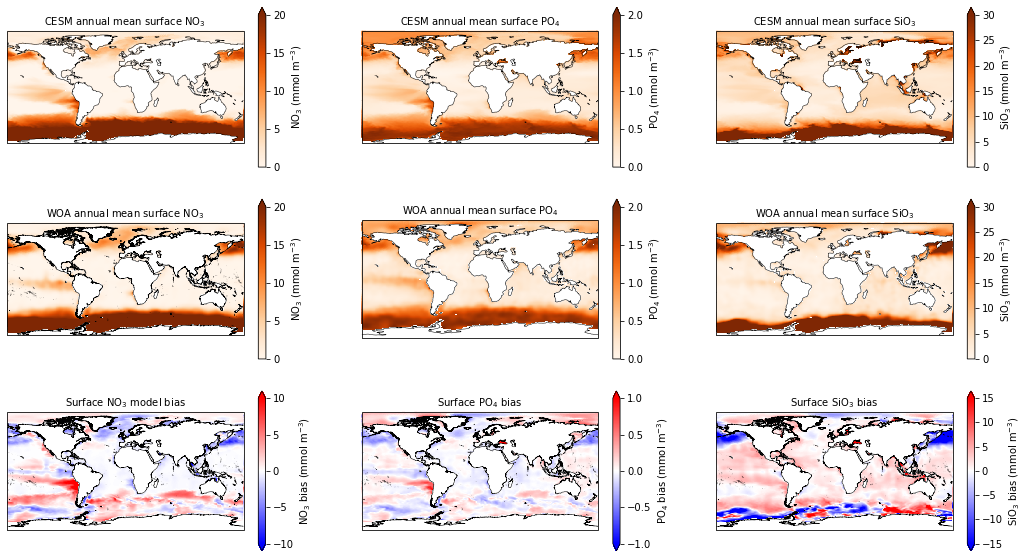

In [27]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
field = cesm_ann_ds.NO3.isel(z_l=0)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=20, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
field = (ds_woa.n_an.isel(z_l=0)).squeeze() #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=20, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  NO3_diff.isel(z_l=0))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
field = cesm_ann_ds.PO4.isel(z_l=0)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=2, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
field = (ds_woa.p_an.isel(z_l=0)).squeeze() #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=2, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  PO4_diff.isel(z_l=0))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
field = cesm_ann_ds.SiO3.isel(z_l=0)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
field = (ds_woa.i_an.isel(z_l=0)).squeeze()  #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  SiO3_diff.isel(z_l=0))
pc3=ax.pcolormesh(lon, lat, 
                  field, 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



### 500m nutrient biases

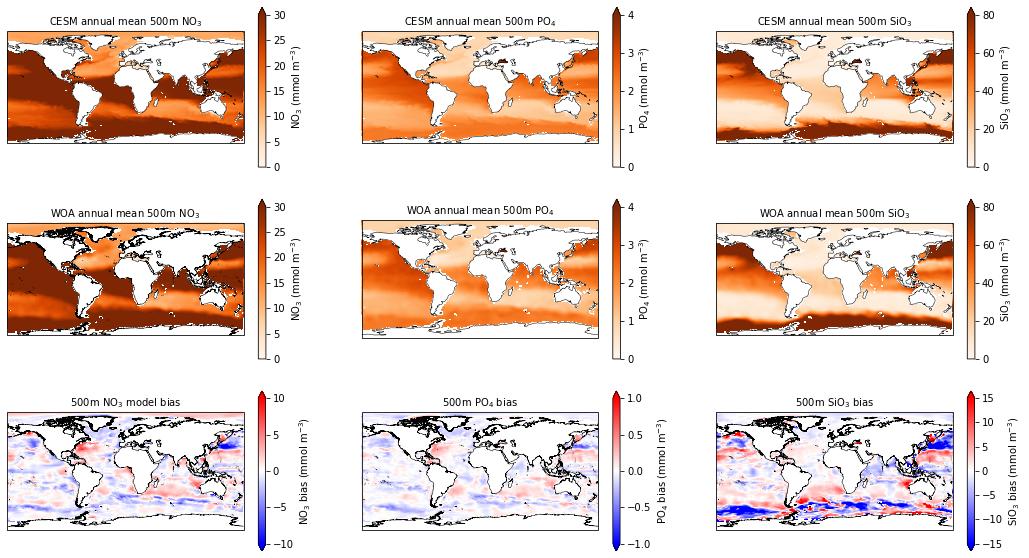

In [28]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean 500m NO$_3$', fontsize=10)
field = cesm_ann_ds.NO3.isel(z_l=13)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=30, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean 500m NO$_3$', fontsize=10)
field = (ds_woa.n_an.isel(z_l=13)).squeeze() #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=30, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('500m NO$_3$ model bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  NO3_diff.isel(z_l=13))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean 500m PO$_4$', fontsize=10)
field = cesm_ann_ds.PO4.isel(z_l=13)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=4, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA annual mean 500m PO$_4$', fontsize=10)
field = (ds_woa.p_an.isel(z_l=13)).squeeze() #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=4, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('500m PO$_4$ bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  PO4_diff.isel(z_l=13))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean 500m SiO$_3$', fontsize=10)
field = cesm_ann_ds.SiO3.isel(z_l=13)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=80, 
                  cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA annual mean 500m SiO$_3$', fontsize=10)
field = (ds_woa.i_an.isel(z_l=13)).squeeze()  #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=80, 
                  cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('500m SiO$_3$ bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  SiO3_diff.isel(z_l=13))
pc3=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



### Seasonal drawdown of nutrients: nutmax - nutmin

In [29]:
path = '/glade/work/kristenk/WOA_data'

files = []
for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    files = files + [path+'/woa18_all_n'+month+'_01.nc']
    
ds_tmp = xr.open_mfdataset(files, decode_times=False, decode_coords=False)

files = []
for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    files = files + [path+'/woa18_all_p'+month+'_01.nc']
    
ds_tmp2 = xr.open_mfdataset(files, decode_times=False, decode_coords=False)

files = []
for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    files = files + [path+'/woa18_all_i'+month+'_01.nc']
    
ds_tmp3 = xr.open_mfdataset(files, decode_times=False, decode_coords=False)

ds_woa_monclim = xr.merge([ds_tmp,ds_tmp2,ds_tmp3])

#convert units to model units
for v in ['n_an','p_an','i_an']:
    ds_woa_monclim[v] = ds_woa_monclim[v] * 1.026
    ds_woa_monclim[v].attrs['units'] = 'mmol/m3'

In [30]:
drawdown_NO3 = cesm_mon_ds.NO3.isel(z_l=0).max(dim='month') - cesm_mon_ds.NO3.isel(z_l=0).min(dim='month')
drawdown_PO4 = cesm_mon_ds.PO4.isel(z_l=0).max(dim='month') - cesm_mon_ds.PO4.isel(z_l=0).min(dim='month')
drawdown_SiO3 = cesm_mon_ds.SiO3.isel(z_l=0).max(dim='month') - cesm_mon_ds.SiO3.isel(z_l=0).min(dim='month')

drawdown_NO3_woa = ds_woa_monclim.n_an.isel(depth=0).max(dim='time') - ds_woa_monclim.n_an.isel(depth=0).min(dim='time')
drawdown_PO4_woa = ds_woa_monclim.p_an.isel(depth=0).max(dim='time') - ds_woa_monclim.p_an.isel(depth=0).min(dim='time')
drawdown_SiO3_woa = ds_woa_monclim.i_an.isel(depth=0).max(dim='time') - ds_woa_monclim.i_an.isel(depth=0).min(dim='time')

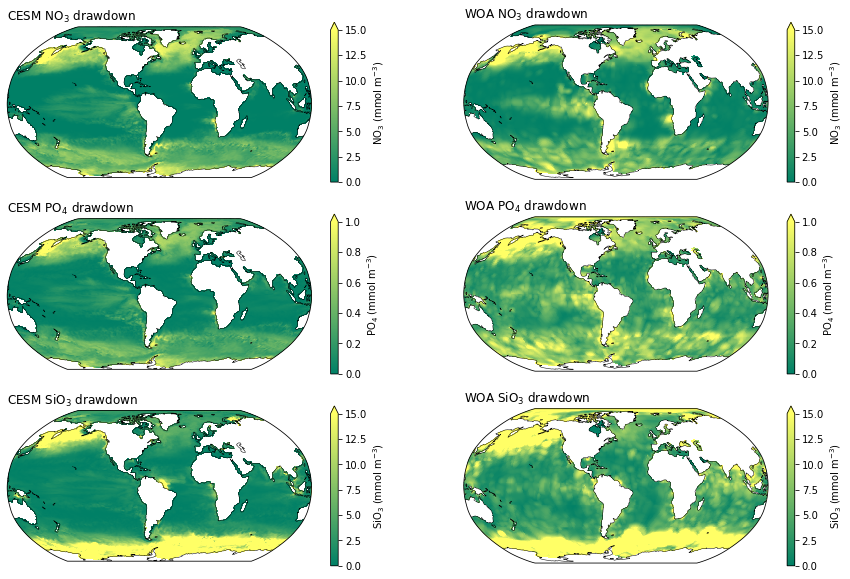

In [31]:
fig = plt.figure(figsize=(15,10))

#################### NO3 drawdown

#---- CESM panel
ax = fig.add_subplot(3,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM NO$_3$ drawdown', fontsize=12, loc='left')
pc1=ax.pcolormesh(lons, lats, drawdown_NO3, 
                  vmin=0, vmax=15, cmap='summer',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')
#---- WOA panel
ax = fig.add_subplot(3,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA NO$_3$ drawdown', fontsize=12, loc='left')
pc1=ax.pcolormesh(ds_woa_monclim.lon, ds_woa_monclim.lat, drawdown_NO3_woa, 
                  vmin=0, vmax=15, cmap='summer',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#################### PO4 drawdown

#---- CESM panel
ax = fig.add_subplot(3,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM PO$_4$ drawdown', fontsize=12, loc='left')
pc1=ax.pcolormesh(lons, lats, drawdown_PO4, 
                  vmin=0, vmax=1, cmap='summer',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')
#---- WOA panel
ax = fig.add_subplot(3,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA PO$_4$ drawdown', fontsize=12, loc='left')
pc1=ax.pcolormesh(ds_woa_monclim.lon, ds_woa_monclim.lat, drawdown_PO4_woa, 
                  vmin=0, vmax=1, cmap='summer',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#################### SiO3 drawdown

#---- CESM panel
ax = fig.add_subplot(3,2,5, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM SiO$_3$ drawdown', fontsize=12, loc='left')
pc1=ax.pcolormesh(lons, lats, drawdown_SiO3, 
                  vmin=0, vmax=15, cmap='summer',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')
#---- WOA panel
ax = fig.add_subplot(3,2,6, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA SiO$_3$ drawdown', fontsize=12, loc='left')
pc1=ax.pcolormesh(ds_woa_monclim.lon, ds_woa_monclim.lat, drawdown_SiO3_woa, 
                  vmin=0, vmax=15, cmap='summer',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

### Global nutrient profiles

In [32]:
##### do global profiles for data already on the CESM grid

area_depth = area.where(cesm_ann_ds.ALK > 0).where(ds_woa['n_an']>0)

ds_glb_nuts = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_l']})

for var in ['NO3','PO4','SiO3','O2','ALK','DIC']:
    ds_glb_nuts[var] = ((cesm_ann_ds[var]*area_depth).sum(dim=('xh','yh'))/(area_depth.sum(dim=('xh','yh')))).compute()


ds_glb_woa = xr.Dataset()

for var in ['n_an','p_an','i_an','o_an']:
    ds_glb_woa[var] = ((ds_woa[var]*area_depth).sum(dim=('xh','yh'))/(area_depth.sum(dim=('xh','yh')))).compute()

In [33]:
### get original WOA data, calculate area, create vertial profile, then take global values and interpolate vertically to the 34 levels of CESM
path = '/glade/work/kristenk/WOA_data'

files = [path+'/woa18_all_n00_01.nc', path+'/woa18_all_p00_01.nc',path+'/woa18_all_i00_01.nc',path+'/woa18_all_o00_01.nc']
ds_woa_x1 = xr.open_mfdataset(files, decode_times=False, decode_coords=False)

ds_woa_x1['n_an'] = ds_woa_x1['n_an'] * 1.026
ds_woa_x1['n_an'].attrs['units'] = 'mmol/m3'
ds_woa_x1['p_an'] = ds_woa_x1['p_an'] * 1.026
ds_woa_x1['p_an'].attrs['units'] = 'mmol/m3'
ds_woa_x1['o_an'] = ds_woa_x1['o_an'] * 1.026
ds_woa_x1['o_an'].attrs['units'] = 'mmol/m3'
ds_woa_x1['i_an'] = ds_woa_x1['i_an'] * 1.026
ds_woa_x1['i_an'].attrs['units'] = 'mmol/m3'

########## calculate area for a regular 1deg 
a = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))

j=0

for lat in ds_woa_x1.lat.values:

    pi = 3.14159265359
    radius = 6378.137
    deg2rad = pi / 180.0
    resolution_lat = 1 #res in degrees
    resolution_lon = 1 #res in degrees
    elevation = deg2rad * (lat + (resolution_lat / 2.0))
    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat
    a[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    j = j + 1

ds_woa_x1['area'] = a

########## create area depth for the regular 1°
area_depth_woa = ds_woa_x1.area.where(ds_woa_x1.n_an > 0).squeeze()

######## now make a global profile for the WOA
ds_glb_woa_x1 = xr.Dataset({v: ds_woa_x1[v] for v in ['depth']})

for var in ['n_an','p_an','o_an','i_an']:
    ds_glb_woa_x1[var] = ((ds_woa_x1[var]*area_depth_woa).sum(dim=('lon','lat'))/(area_depth_woa.sum(dim=('lon','lat')))).compute()
    ds_glb_woa_x1[var].attrs = ds_woa_x1[var].attrs
    
### now regrid vertically the WOA profile which has 102 levels so that it has the 34 CESM levels
ds_glb_woa_x1_34lev = xr.Dataset()
z = cesm_ann_ds.z_l.values
ds_glb_woa_x1 = ds_glb_woa_x1.rename({'depth' : 'z_l'})
grid = Grid(ds_glb_woa_x1, coords={'Z': {'center':'z_l'}}, periodic=False)

for var in ['n_an','p_an','o_an','i_an']:

    var_vertregrid = grid.transform(ds_glb_woa_x1[var], 'Z', z, target_data=ds_glb_woa_x1.z_l)
    ds_glb_woa_x1_34lev[var] = var_vertregrid
    ds_glb_woa_x1_34lev[var].attrs = ds_woa_x1[var].attrs

ds_glb_woa_x1_34lev = ds_glb_woa_x1_34lev.squeeze()

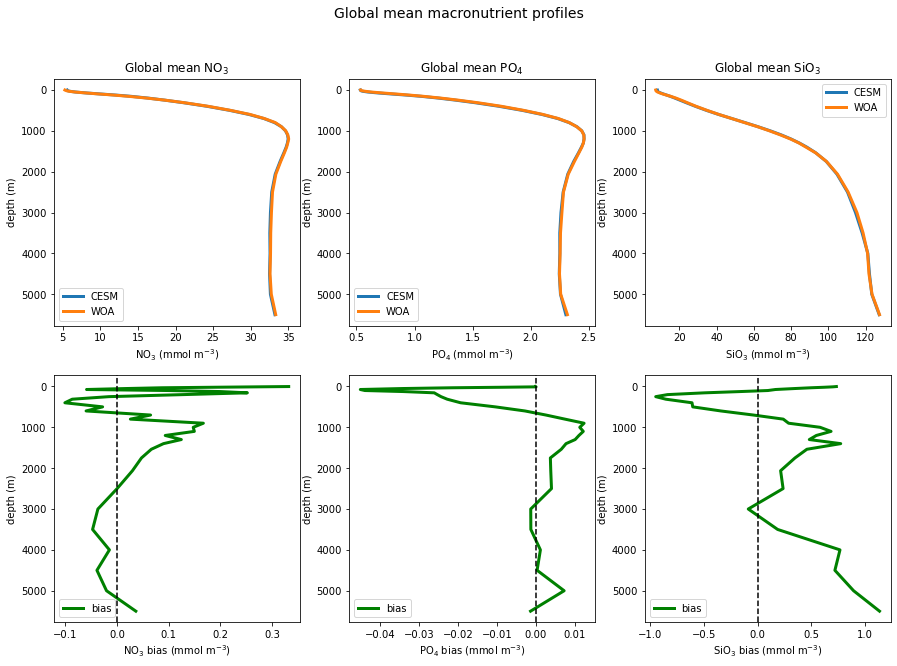

In [34]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb_nuts['NO3'], depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['n_an'], depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb_nuts['PO4'], depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['p_an'], depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb_nuts['SiO3'], depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['i_an'], depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb_nuts['NO3'].values - ds_glb_woa_x1_34lev['n_an'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.axvline(0,linestyle='--',color='black')
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb_nuts['PO4'].values - ds_glb_woa_x1_34lev['p_an'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.axvline(0,linestyle='--',color='black')
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb_nuts['SiO3'].values - ds_glb_woa_x1_34lev['i_an'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.axvline(0,linestyle='--',color='black')
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



### Southern Ocean nutrient profiles

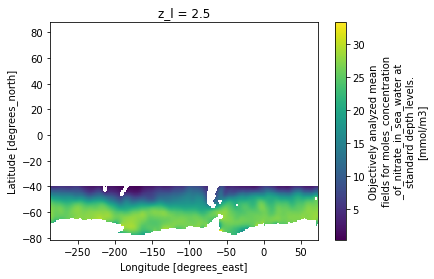

In [35]:
ds_woa['n_an'].where(ds_woa.yh<-40).isel(z_l=0).plot()

In [36]:
ds_SO_woa = xr.Dataset()
ds_SO_woa['NO3'] = (((ds_woa['n_an']).where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()
ds_SO_woa['PO4'] = (((ds_woa['p_an']).where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()
ds_SO_woa['SiO3'] = (((ds_woa['i_an']).where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()
ds_SO_woa['O2'] = (((ds_woa['o_an']).where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()
ds_SO_woa = ds_SO_woa.squeeze()

In [37]:
ds_SO_nuts = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_l']})
ds_SO_nuts['NO3'] = ((cesm_ann_ds['NO3'].where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()
ds_SO_nuts['PO4'] = ((cesm_ann_ds['PO4'].where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()
ds_SO_nuts['SiO3'] = ((cesm_ann_ds['SiO3'].where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()
ds_SO_nuts['O2'] = ((cesm_ann_ds['O2'].where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()

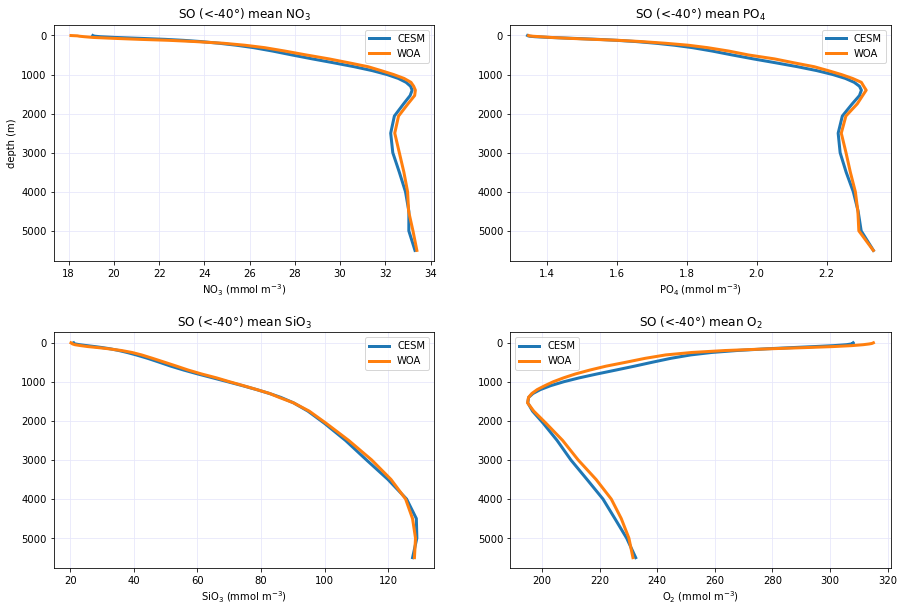

In [38]:
fig = plt.figure(figsize=(15,10))

#COLUMN 1  - NO3

ax = fig.add_subplot(2,2,1)
ax.set_title('SO (<-40°) mean NO$_3$')
ax.plot(ds_SO_nuts['NO3'], depths, label='CESM', linewidth=3)
ax.plot(ds_SO_woa['NO3'], depths, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,2,2)
ax.set_title('SO (<-40°) mean PO$_4$')
ax.plot(ds_SO_nuts['PO4'], depths, label='CESM', linewidth=3)
ax.plot(ds_SO_woa['PO4'], depths, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,2,3)
ax.set_title('SO (<-40°) mean SiO$_3$')
ax.plot(ds_SO_nuts['SiO3'], depths, label='CESM', linewidth=3)
ax.plot(ds_SO_woa['SiO3'], depths, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - O2

ax = fig.add_subplot(2,2,4)
ax.set_title('SO (<-40°) mean O$_2$')
ax.plot(ds_SO_nuts['O2'], depths, label='CESM', linewidth=3)
ax.plot(ds_SO_woa['O2'], depths, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

fig.subplots_adjust(hspace=0.3)

## profiles for DIC and ALK

In [39]:
file ='/glade/work/kristenk/GLODAPv2_regridded/mom6_2_3_regrid/GLODAPvars_mom6grid.nc'
ds_glodap = xr.open_dataset(file, decode_times=False, decode_coords=False)

### convert from µmol/kg to mmol/m3
ds_glodap['PI_TCO2'] = ds_glodap['PI_TCO2'] * 1.026
ds_glodap['PI_TCO2'].attrs['units'] = 'mmol/m3'

ds_glodap['TAlk'] = ds_glodap['TAlk'] * 1.026
ds_glodap['TAlk'].attrs['units'] = 'mmol/m3'

ds_glodap['TCO2'] = ds_glodap['TCO2'] * 1.026
ds_glodap['TCO2'].attrs['units'] = 'mmol/m3'

In [40]:
ds_SO_nuts['DIC'] = ((cesm_ann_ds['DIC'].where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()
ds_SO_nuts['ALK'] = ((cesm_ann_ds['ALK'].where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).sum(dim=('xh','yh')))).compute()

In [41]:
ds_glb_nuts['DIC'] = ((cesm_ann_ds['DIC']*area_depth).sum(dim=('xh','yh'))/(area_depth.sum(dim=('xh','yh')))).compute()
ds_glb_nuts['ALK'] = ((cesm_ann_ds['ALK']*area_depth).sum(dim=('xh','yh'))/(area_depth.sum(dim=('xh','yh')))).compute()

In [42]:
ds_SO_woa['DIC'] = ((ds_glodap['PI_TCO2'].where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).where(ds_glodap['PI_TCO2']>0).sum(dim=('xh','yh')))).compute()
ds_SO_woa['ALK'] = ((ds_glodap['TAlk'].where(lats<-40)*area_depth).sum(dim=('xh','yh'))/(area_depth.where(lats<-40).where(ds_glodap['TAlk']>0).sum(dim=('xh','yh')))).compute()

In [43]:
ds_glb_woa['DIC'] = ((ds_glodap['PI_TCO2']*area_depth).sum(dim=('xh','yh'))/(area_depth.where(ds_glodap['PI_TCO2']>0).sum(dim=('xh','yh')))).compute()
ds_glb_woa['ALK'] = ((ds_glodap['TAlk']*area_depth).sum(dim=('xh','yh'))/(area_depth.where(ds_glodap['TAlk']>0).sum(dim=('xh','yh')))).compute()

In [44]:
### get original GLODAP data, calculate area, create vertial profile, then take global values and interpolate vertically to the 34 levels of CESM
path = '/glade/work/kristenk/GLODAPv2_regridded/'
files =[path+'TAlk_GLODAP_normal1deg_33depths.nc', path+'PI_TCO2_GLODAP_normal1deg_33depths.nc']
ds_glodap_x1 = xr.open_mfdataset(files, decode_times=False, decode_coords=False)

ds_glodap_x1['PI_TCO2'] = ds_glodap_x1['PI_TCO2'] * 1.026
ds_glodap_x1['PI_TCO2'].attrs['units'] = 'mmol/m3'
ds_glodap_x1['TAlk'] = ds_glodap_x1['TAlk'] * 1.026
ds_glodap_x1['TAlk'].attrs['units'] = 'mmol/m3'

########## calculate area for a regular 1deg 
a = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))

j=0

for lat in ds_glodap_x1.lat.values:

    pi = 3.14159265359
    radius = 6378.137
    deg2rad = pi / 180.0
    resolution_lat = 1 #res in degrees
    resolution_lon = 1 #res in degrees
    elevation = deg2rad * (lat + (resolution_lat / 2.0))
    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat
    a[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    j = j + 1

ds_glodap_x1['area'] = a

########## create area depth for the regular 1°
area_depth_glodap = ds_glodap_x1.area.where(ds_glodap_x1.TAlk > 0).squeeze()

######## now make a global profile for GLODAP
ds_glb_glodap_x1 = xr.Dataset({v: ds_glodap_x1[v] for v in ['depth_surface']})

for var in ['PI_TCO2','TAlk']:
    ds_glb_glodap_x1[var] = ((ds_glodap_x1[var]*area_depth_glodap).sum(dim=('lon','lat'))/(area_depth_glodap.sum(dim=('lon','lat')))).compute()
    ds_glb_glodap_x1[var].attrs = ds_glodap_x1[var].attrs
    
### now regrid vertically the WOA profile which has 102 levels so that it has the 34 CESM levels
ds_glb_glodap_x1_34lev = xr.Dataset()
z = cesm_ann_ds.z_l.values
ds_glb_glodap_x1 = ds_glb_glodap_x1.rename({'depth_surface' : 'z_l'})
grid = Grid(ds_glb_glodap_x1, coords={'Z': {'center':'z_l'}}, periodic=False)

for var in ['PI_TCO2','TAlk']:

    var_vertregrid = grid.transform(ds_glb_glodap_x1[var], 'Z', z, target_data=ds_glb_glodap_x1.z_l)
    ds_glb_glodap_x1_34lev[var] = var_vertregrid
    ds_glb_glodap_x1_34lev[var].attrs = ds_glodap_x1[var].attrs

ds_glb_glodap_x1_34lev = ds_glb_glodap_x1_34lev.squeeze()

######## now make a Southern Ocean profile for GLODAP

ds_SO_glodap_x1 = xr.Dataset({v: ds_glodap_x1[v] for v in ['depth_surface']})

for var in ['PI_TCO2','TAlk']:
    ds_SO_glodap_x1[var] = ((ds_glodap_x1[var]*area_depth_glodap).where(ds_glodap_x1.lat<-40).sum(dim=('lon','lat'))/(area_depth_glodap.where(ds_glodap_x1.lat<-40).sum(dim=('lon','lat')))).compute()
    ds_SO_glodap_x1[var].attrs = ds_glodap_x1[var].attrs
    
### now regrid vertically the WOA profile which has 102 levels so that it has the 34 CESM levels
ds_SO_glodap_x1_34lev = xr.Dataset()
z = cesm_ann_ds.z_l.values
ds_SO_glodap_x1 = ds_SO_glodap_x1.rename({'depth_surface' : 'z_l'})
grid = Grid(ds_SO_glodap_x1, coords={'Z': {'center':'z_l'}}, periodic=False)

for var in ['PI_TCO2','TAlk']:

    var_vertregrid = grid.transform(ds_SO_glodap_x1[var], 'Z', z, target_data=ds_SO_glodap_x1.z_l)
    ds_SO_glodap_x1_34lev[var] = var_vertregrid
    ds_SO_glodap_x1_34lev[var].attrs = ds_glodap_x1[var].attrs

ds_SO_glodap_x1_34lev = ds_SO_glodap_x1_34lev.squeeze()

### Global profiles for ALK and DIC

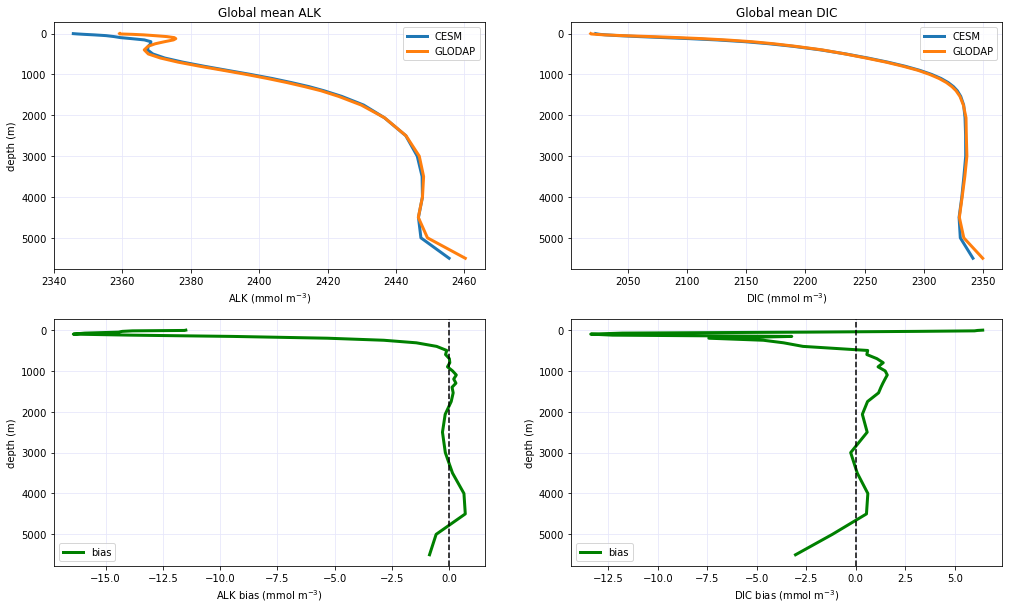

In [45]:
fig = plt.figure(figsize=(17,10))

#COLUMN 1  - ALK

ax = fig.add_subplot(2,2,1)
ax.set_title('Global mean ALK')
ax.plot(ds_glb_nuts['ALK'], depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['ALK'], depths, label='GLODAP', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(ylabel='depth (m)',xlabel='ALK (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - DIC

ax = fig.add_subplot(2,2,2)
ax.set_title('Global mean DIC')
ax.plot(ds_glb_nuts['DIC'], depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['DIC'], depths, label='GLODAP', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(xlabel='DIC (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

# diff Alk


ax = fig.add_subplot(2,2,3)
ax.plot(ds_glb_nuts['ALK'] - ds_glb_glodap_x1_34lev['TAlk'], depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.axvline(0,linestyle='--',color='black')
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(ylabel='depth (m)',xlabel='ALK bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

# diff DIC

ax = fig.add_subplot(2,2,4)
ax.plot(ds_glb_nuts['DIC'] - ds_glb_glodap_x1_34lev['PI_TCO2'], depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.axvline(0,linestyle='--',color='black')
ax.set(ylabel='depth (m)',xlabel='DIC bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


### Southern Ocean (<40°S) profiles for ALK and DIC

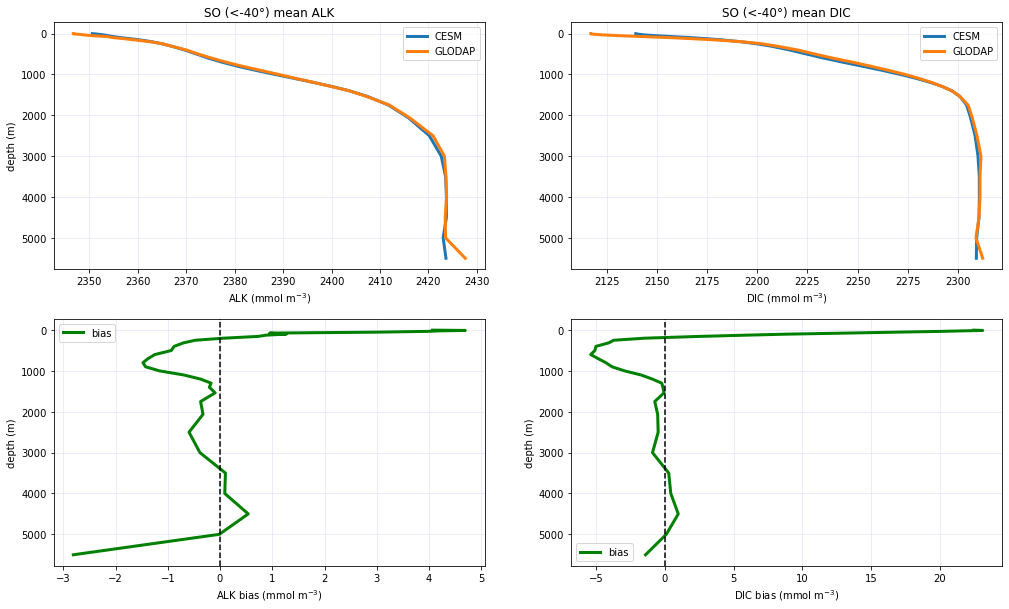

In [46]:
fig = plt.figure(figsize=(17,10))

#COLUMN 1  - ALK

ax = fig.add_subplot(2,2,1)
ax.set_title('SO (<-40°) mean ALK')
ax.plot(ds_SO_nuts['ALK'], depths, label='CESM', linewidth=3)
ax.plot(ds_SO_woa['ALK'], depths, label='GLODAP', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(ylabel='depth (m)',xlabel='ALK (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - DIC

ax = fig.add_subplot(2,2,2)
ax.set_title('SO (<-40°) mean DIC')
ax.plot(ds_SO_nuts['DIC'], depths, label='CESM', linewidth=3)
ax.plot(ds_SO_woa['DIC'], depths, label='GLODAP', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(xlabel='DIC (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

# diff Alk


ax = fig.add_subplot(2,2,3)
ax.plot(ds_SO_nuts['ALK'] - ds_SO_glodap_x1_34lev['TAlk'], depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.axvline(0,linestyle='--',color='black')
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set(ylabel='depth (m)',xlabel='ALK bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

# diff DIC

ax = fig.add_subplot(2,2,4)
ax.plot(ds_SO_nuts['DIC'] - ds_SO_glodap_x1_34lev['PI_TCO2'], depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.axvline(0,linestyle='--',color='black')
ax.set(ylabel='depth (m)',xlabel='DIC bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


### Oxygen plots

In [47]:
cesm_ann_ds.z_l[13].values

array(500.)

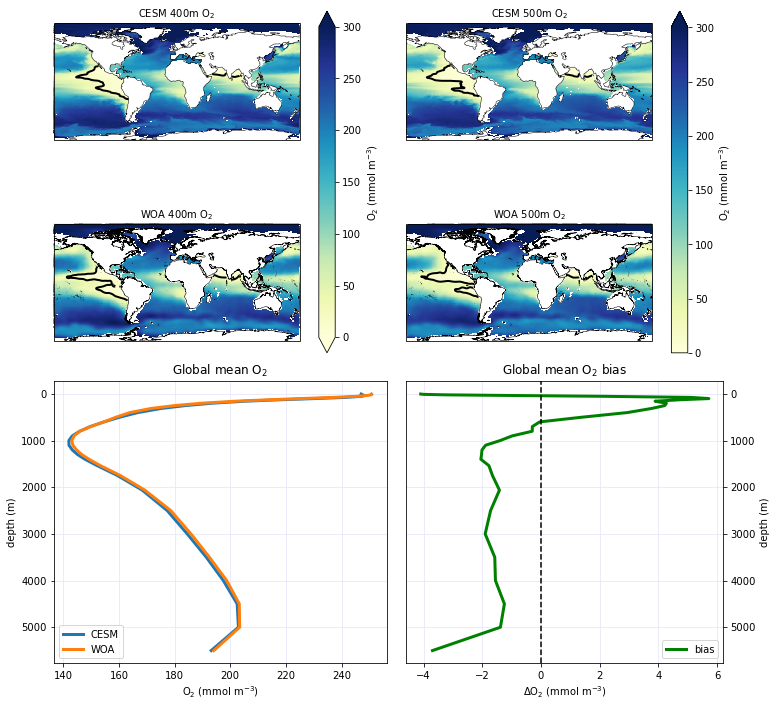

In [48]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(nrows=4, ncols=6, width_ratios=(1.5, 0.1, 0.2, 1.5, 0.1, 0.1),height_ratios=(1,0.02,1,2))

prj = ccrs.PlateCarree()

ax_mapC400 = plt.subplot(gs[0, 0], projection=prj)
ax_mapC500 = plt.subplot(gs[0, 3], projection=prj)
ax_mapO400 = plt.subplot(gs[2, 0], projection=prj)
ax_mapO500 = plt.subplot(gs[2, 3], projection=prj)
ax_cbsurf = plt.subplot(gs[0:3, 1])
ax_cb500m = plt.subplot(gs[0:3, 4])
ax_profile = plt.subplot(gs[3, 0:3])
ax_profile_diff = plt.subplot(gs[3, 3:6])

# SURFACE O2
#---- CESM panel
ax_mapC400.coastlines('110m',linewidth=0.5)
ax_mapC400.set_title('CESM 400m O$_2$', fontsize=10)
field = cesm_ann_ds.O2.isel(z_l=12)
pci=ax_mapC400.contour(lons, lats, field,levels=[20],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
pc1=ax_mapC400.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=300, 
                  cmap='YlGnBu',
                  transform=ccrs.PlateCarree())
#---- OBS panel
ax_mapO400.coastlines('10m',linewidth=0.5)
ax_mapO400.set_title('WOA 400m O$_2$', fontsize=10)
field = (ds_woa.o_an.isel(z_l=12)).squeeze() #convert from µmol/kg to mmol/m3
pci=ax_mapO400.contour(lons, lats, field,levels=[20],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
pc2=ax_mapO400.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=300, 
                  cmap='YlGnBu',
                  transform=ccrs.PlateCarree())

#------ color bar surface
cbar1 = fig.colorbar(pc2, cax=ax_cbsurf, extend='both',label='O$_2$ (mmol m$^{-3}$)')

# 500m O2
#---- CESM panel
ax_mapC500.coastlines('110m',linewidth=0.5)
ax_mapC500.set_title('CESM 500m O$_2$', fontsize=10)
field = cesm_ann_ds.O2.isel(z_l=13)
pci=ax_mapC500.contour(lons, lats, field,levels=[20],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
pc1=ax_mapC500.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=300, 
                  cmap='YlGnBu',
                  transform=ccrs.PlateCarree())

#---- OBS panel
ax_mapO500.coastlines('10m',linewidth=0.5)
ax_mapO500.set_title('WOA 500m O$_2$', fontsize=10)
field = (ds_woa.o_an.isel(z_l=13)).squeeze() #convert from µmol/kg to mmol/m3
pci=ax_mapO500.contour(lons, lats, field,levels=[20],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
pc2=ax_mapO500.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=300, 
                  cmap='YlGnBu',
                  transform=ccrs.PlateCarree())
# -- color bar 500m
cbar1 = fig.colorbar(pc2, cax=ax_cb500m, extend='max',label='O$_2$ (mmol m$^{-3}$)')

######### global average profile

ax_profile.set_title('Global mean O$_2$')
ax_profile.plot(ds_glb_nuts['O2'], depths, label='CESM', linewidth=3)
ax_profile.plot(ds_glb_woa['o_an'], depths, label='WOA', linewidth=3)
ax_profile.legend()
ax_profile.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
ax_profile.xaxis.grid(True, which='major',color='lavender')
ax_profile.yaxis.grid(True, which='major',color='lavender');
ax_profile.yaxis.set_inverted(True)  # inverted axis with autoscaling

######### global average profile bias

ax_profile_diff.set_title('Global mean O$_2$ bias')
ax_profile_diff.plot(ds_glb_nuts['O2'].values - ds_glb_woa_x1_34lev['o_an'].values, depths, label='bias', linewidth=3, color='green')
ax_profile_diff.legend()
ax_profile_diff.axvline(0,linestyle='--',color='black')
ax_profile_diff.set(ylabel='depth (m)',xlabel='${\Delta}$O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
ax_profile_diff.xaxis.grid(True, which='major',color='lavender')
ax_profile_diff.yaxis.grid(True, which='major',color='lavender');
ax_profile_diff.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True, right=True, labelright=True, left=False, labelleft=False)
ax_profile_diff.yaxis.set_label_position("right")
ax_profile_diff.yaxis.set_inverted(True)  # inverted axis with autoscaling

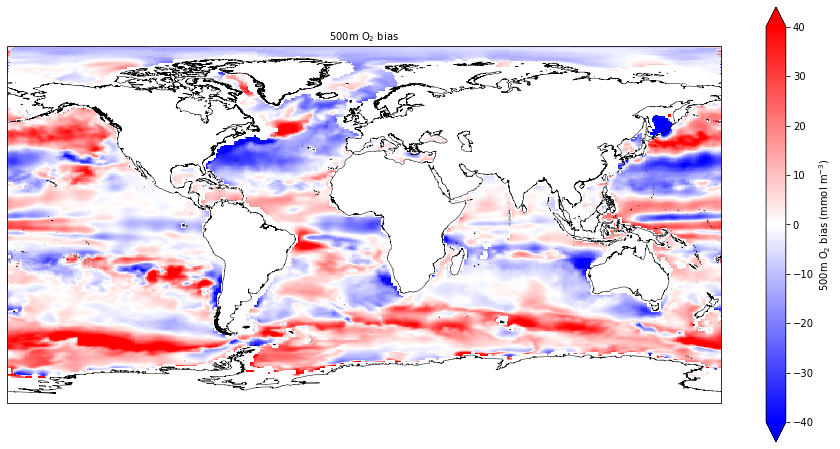

In [49]:
fig = plt.figure(figsize=(16,8))


#---- DIFF panel
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('500m O$_2$ bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  O2_diff.isel(z_l=13))
pc3=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=-40, vmax=40, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='500m O$_2$ bias (mmol m$^{-3}$)')

### zonal means: Nutrients, O2

In [50]:
import xesmf

In [51]:
def zonal_mean(ds_in, varname, ds_grid):

    grid_in = ds_grid2.rename({'geolon': 'lon','geolat': 'lat', 'geolonb': 'lon_b',
                            'geolatb': 'lat_b', 'lath' : 'yh', 'lonh' : 'xh',
                            'latq' : 'yq', 'lonq' : 'xq'})

    lon = np.arange(0.5, 360, 1)
    lat = np.arange(-89.5, 90, 1)
    
    ds_out = xr.Dataset({"lon": (["lon"], lon),"lat": (["lat"], lat)})

    ds_in = ds_in.assign_coords(lat=grid_in.lat, lat_b=grid_in.lat_b, lon=grid_in.lon, lon_b=grid_in.lon_b)
    
    def regrid_tracer(varname, ds_in, ds_out, method='bilinear'):
    
        regrid = xesmf.Regridder(
            ds_in,
            ds_out,
            method=method,
            periodic=True,
        )
        fld_out = regrid(ds_in[varname])
        return fld_out

    var_1x1 = regrid_tracer(varname, ds_in, ds_out)

    za = var_1x1.mean(dim='lon')

    return(za)

In [52]:
ds_zonal_surf = xr.Dataset()
ds_zonal_500m = xr.Dataset()

for var in ['NO3','PO4','SiO3','O2','ALK','DIC']:

    ds_zonal_surf[var] = zonal_mean(cesm_ann_ds.isel(z_l=0), var, ds_grid)
    ds_zonal_500m[var] = zonal_mean(cesm_ann_ds.isel(z_l=13), var, ds_grid)

In [53]:
ds_zonal_surf_woa = xr.Dataset()
ds_zonal_500m_woa = xr.Dataset()

for var in ['n_an','p_an','i_an','o_an']: #,'ALK','DIC']:

    ds_zonal_surf_woa[var] = zonal_mean(ds_woa.isel(z_l=0), var, ds_grid)
    ds_zonal_500m_woa[var] = zonal_mean(ds_woa.isel(z_l=13), var, ds_grid)

In [54]:
for var in ['TAlk','PI_TCO2']:

    ds_zonal_surf_woa[var] = zonal_mean(ds_glodap.isel(z_l=0), var, ds_grid)
    ds_zonal_500m_woa[var] = zonal_mean(ds_glodap.isel(z_l=13), var, ds_grid)

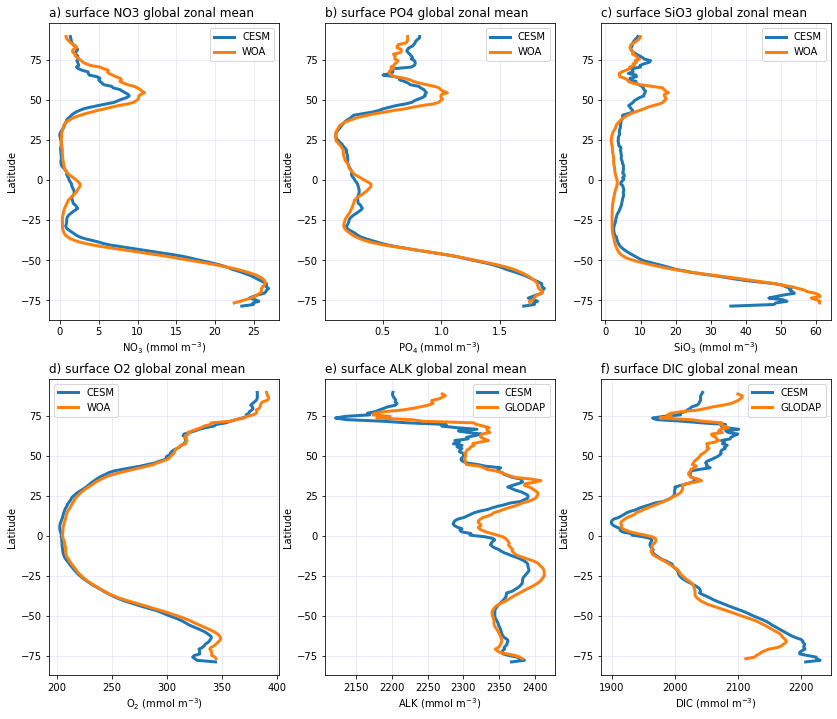

In [55]:
fig = plt.figure(figsize=(14,12))

# NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('a) surface NO3 global zonal mean', loc='left')
ax.plot(ds_zonal_surf['NO3'], ds_zonal_surf.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_surf_woa['n_an'].values, ds_zonal_surf_woa.lat, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='NO$_3$ (mmol m$^{-3}$)')

# PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('b) surface PO4 global zonal mean', loc='left')
ax.plot(ds_zonal_surf['PO4'], ds_zonal_surf.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_surf_woa['p_an'].values, ds_zonal_surf_woa.lat, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='PO$_4$ (mmol m$^{-3}$)')


# SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('c) surface SiO3 global zonal mean', loc='left')
ax.plot(ds_zonal_surf['SiO3'], ds_zonal_surf.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_surf_woa['i_an'].values, ds_zonal_surf_woa.lat, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='SiO$_3$ (mmol m$^{-3}$)')

#  O2

ax = fig.add_subplot(2,3,4)
ax.set_title('d) surface O2 global zonal mean', loc='left')
ax.plot(ds_zonal_surf['O2'], ds_zonal_surf.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_surf_woa['o_an'].values, ds_zonal_surf_woa.lat, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='O$_2$ (mmol m$^{-3}$)');

# ALK

ax = fig.add_subplot(2,3,5)
ax.set_title('e) surface ALK global zonal mean', loc='left')
ax.plot(ds_zonal_surf['ALK'], ds_zonal_surf.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_surf_woa['TAlk'].values, ds_zonal_surf_woa.lat, label='GLODAP', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='ALK (mmol m$^{-3}$)');

# DIC

ax = fig.add_subplot(2,3,6)
ax.set_title('f) surface DIC global zonal mean', loc='left')
ax.plot(ds_zonal_surf['DIC'], ds_zonal_500m.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_surf_woa['PI_TCO2'].values, ds_zonal_surf_woa.lat, label='GLODAP', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='DIC (mmol m$^{-3}$)');

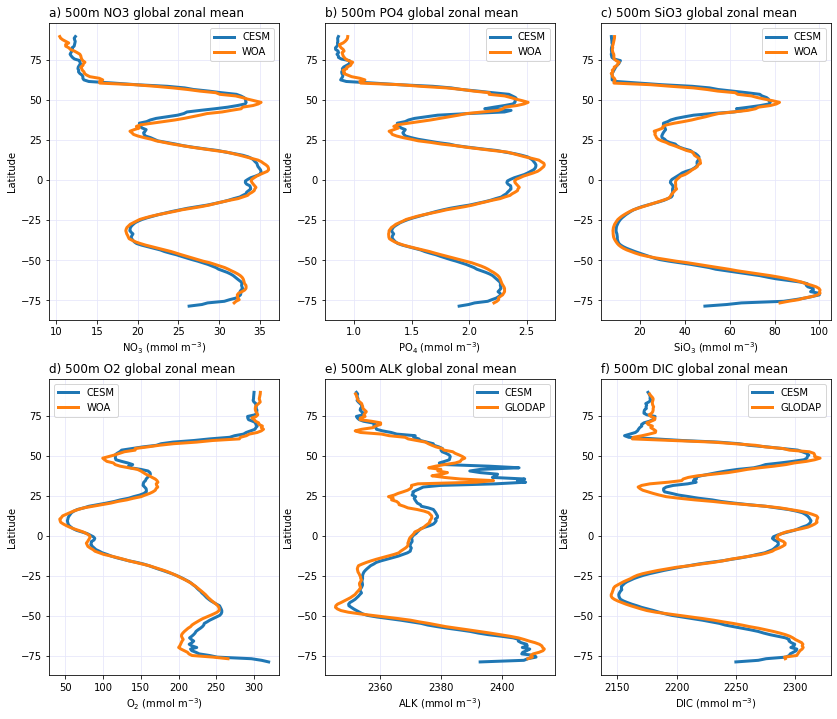

In [56]:
fig = plt.figure(figsize=(14,12))

# NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('a) 500m NO3 global zonal mean', loc='left')
ax.plot(ds_zonal_500m['NO3'], ds_zonal_500m.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_500m_woa['n_an'].values, ds_zonal_500m_woa.lat, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='NO$_3$ (mmol m$^{-3}$)')

# PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('b) 500m PO4 global zonal mean', loc='left')
ax.plot(ds_zonal_500m['PO4'], ds_zonal_500m.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_500m_woa['p_an'].values, ds_zonal_500m_woa.lat, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='PO$_4$ (mmol m$^{-3}$)')

# SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('c) 500m SiO3 global zonal mean', loc='left')
ax.plot(ds_zonal_500m['SiO3'], ds_zonal_500m.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_500m_woa['i_an'].values, ds_zonal_500m_woa.lat, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='SiO$_3$ (mmol m$^{-3}$)')

#  O2

ax = fig.add_subplot(2,3,4)
ax.set_title('d) 500m O2 global zonal mean', loc='left')
ax.plot(ds_zonal_500m['O2'], ds_zonal_500m.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_500m_woa['o_an'].values, ds_zonal_500m_woa.lat, label='WOA', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='O$_2$ (mmol m$^{-3}$)');

#  ALK

ax = fig.add_subplot(2,3,5)
ax.set_title('e) 500m ALK global zonal mean', loc='left')
ax.plot(ds_zonal_500m['ALK'], ds_zonal_500m.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_500m_woa['TAlk'].values, ds_zonal_500m_woa.lat, label='GLODAP', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='ALK (mmol m$^{-3}$)');

ax = fig.add_subplot(2,3,6)
ax.set_title('f) 500m DIC global zonal mean', loc='left')
ax.plot(ds_zonal_500m['DIC'], ds_zonal_500m.lat, label='CESM', linewidth=3)
ax.plot(ds_zonal_500m_woa['PI_TCO2'].values, ds_zonal_500m_woa.lat, label='GLODAP', linewidth=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender')
ax.set(ylabel='Latitude',xlabel='DIC (mmol m$^{-3}$)');

## Global air-sea CO2 flux and POC export

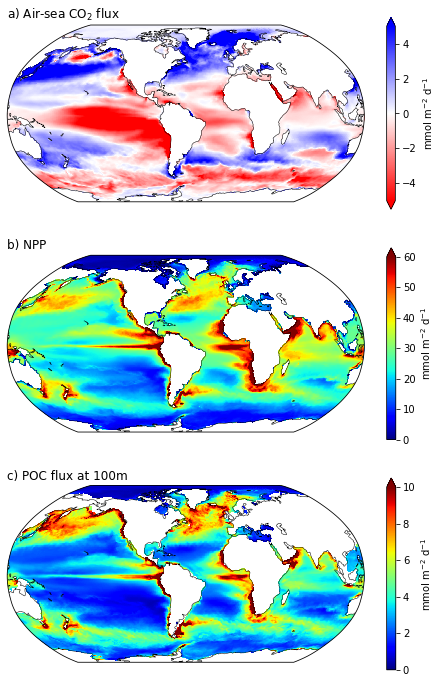

In [57]:
fig = plt.figure(figsize=(8,12))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) Air-sea CO$_2$ flux', fontsize=12,loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds2.FG_CO2 * 86400.)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr_r',
                 vmin=-5,vmax=5,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='mmol m$^{-2}$ d$^{-1}$')


ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) NPP', fontsize=12,loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds2.photoC_TOT_zint * 86400.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 vmin=0,vmax=60,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol m$^{-2}$ d$^{-1}$')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) POC flux at 100m', fontsize=12,loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds2.POC_FLUX_100m * 86400.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 vmin=0,vmax=10,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol m$^{-2}$ d$^{-1}$');

### Plot up C:N phytoplankton ratios

### Phytoplankton nutrient limitation at surface

In [58]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_ann_ds2.sp_P_lim_surf, cesm_ann_ds2.sp_Fe_lim_surf,cesm_ann_ds2.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_ann_ds2.diat_P_lim_surf, cesm_ann_ds2.diat_Fe_lim_surf, cesm_ann_ds2.diat_N_lim_surf, cesm_ann_ds2.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_ann_ds2.diaz_P_lim_surf, cesm_ann_ds2.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_ann_ds2.cocco_P_lim_surf, cesm_ann_ds2.cocco_Fe_lim_surf, cesm_ann_ds2.cocco_N_lim_surf, cesm_ann_ds2.cocco_C_lim_surf),dim='nutrient')

In [59]:
most_lim_sp = limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diat = limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diaz = limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_cocco = limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()
mask = np.isnan(cesm_ann_ds2.sp_N_lim_surf.squeeze())

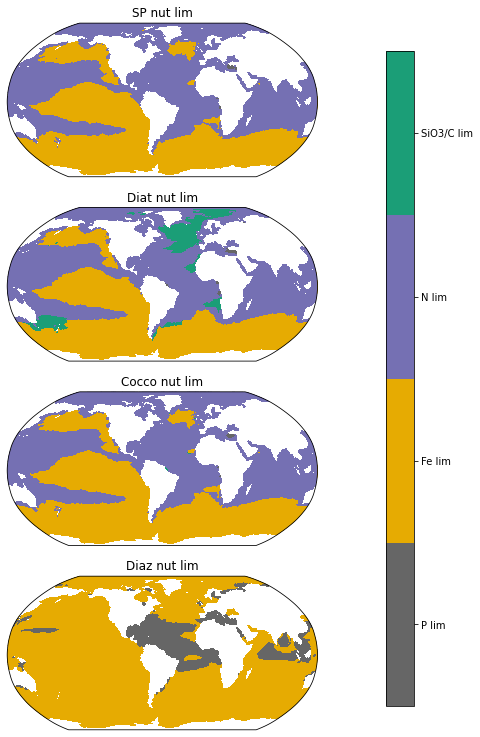

In [60]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
field = most_lim_diat.where(~mask)
pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
field = most_lim_sp.where(~mask)
pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco nut lim', fontsize=12)
field = most_lim_cocco.where(~mask)
pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
field = most_lim_diaz.where(~mask)
pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Monthly nutrient limitations

In [61]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_mon_ds2.sp_P_lim_surf, cesm_mon_ds2.sp_Fe_lim_surf,cesm_mon_ds2.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_mon_ds2.diat_P_lim_surf, cesm_mon_ds2.diat_Fe_lim_surf, cesm_mon_ds2.diat_N_lim_surf, cesm_mon_ds2.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_mon_ds2.diaz_P_lim_surf, cesm_mon_ds2.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_mon_ds2.cocco_P_lim_surf, cesm_mon_ds2.cocco_Fe_lim_surf, cesm_mon_ds2.cocco_N_lim_surf, cesm_mon_ds2.cocco_C_lim_surf),dim='nutrient')

In [62]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()
mask = np.isnan(cesm_ann_ds2.sp_N_lim_surf.squeeze())

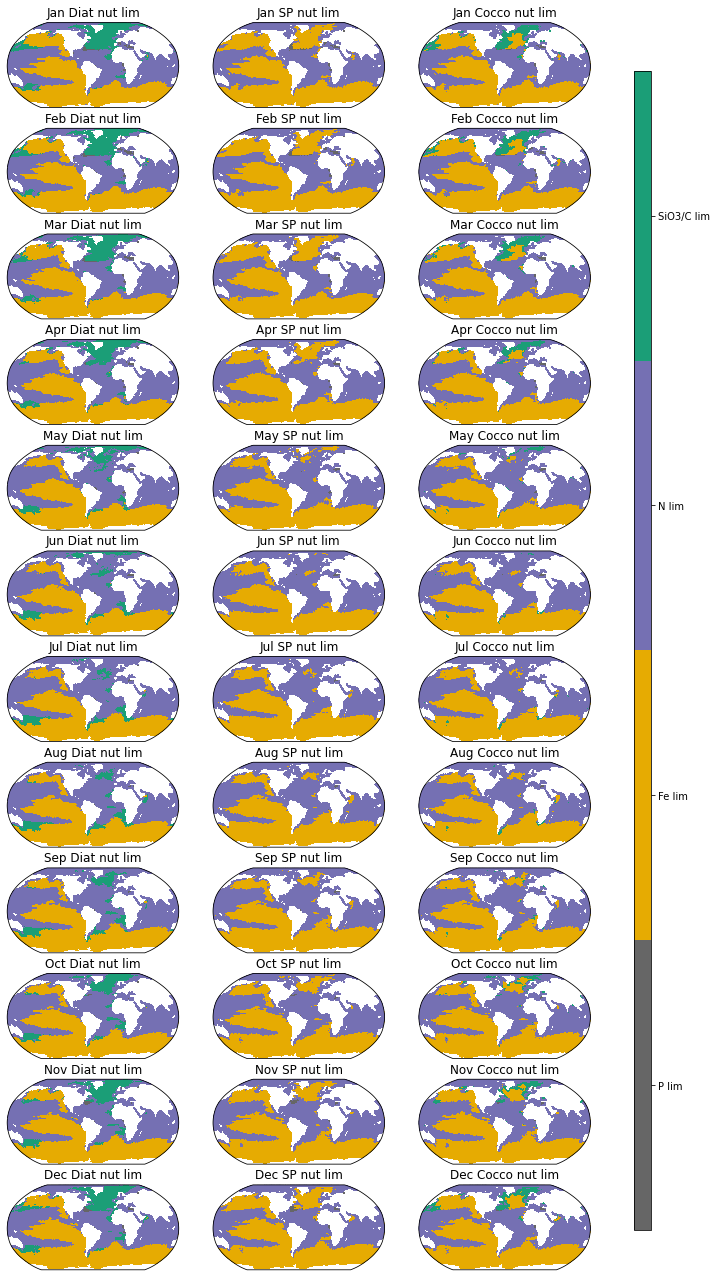

In [63]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' Diat nut lim', fontsize=12)
    field = most_lim_diat.isel(month=ts).where(~mask)
    pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' SP nut lim', fontsize=12)
    field = most_lim_sp.isel(month=ts).where(~mask)
    pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' Cocco nut lim', fontsize=12)
    field = most_lim_cocco.isel(month=ts).where(~mask)
    pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

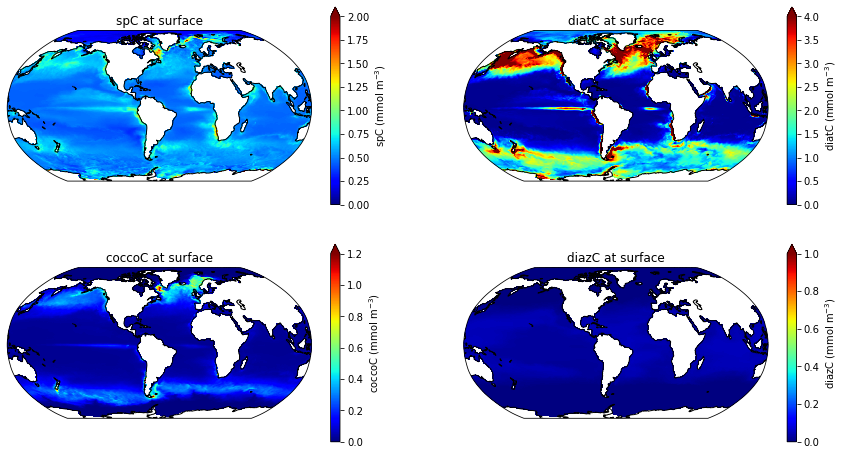

In [104]:
###### 
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoC.isel(z_l=0), cmap='jet',vmin=0,vmax=1.2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diatC.isel(z_l=0), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.spC.isel(z_l=0), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diazC.isel(z_l=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

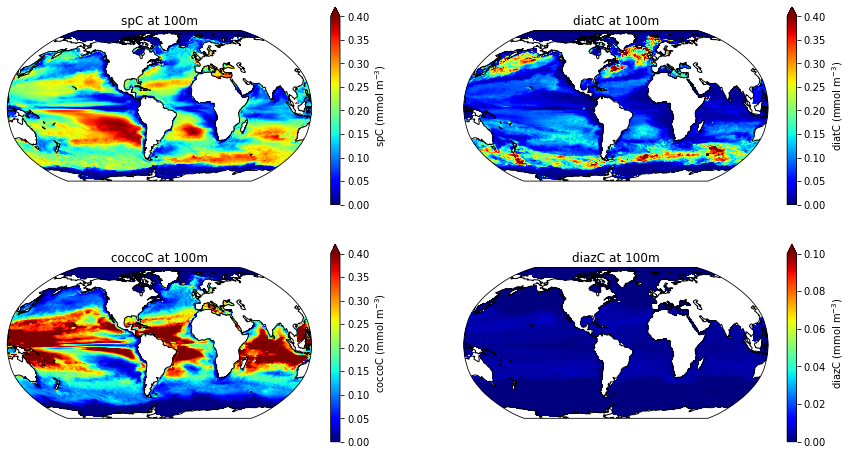

In [105]:
###### 
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at 100m', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoC.isel(z_l=6), cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diatC.isel(z_l=6), cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.spC.isel(z_l=6), cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diazC.isel(z_l=6), cmap='jet',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton production maps

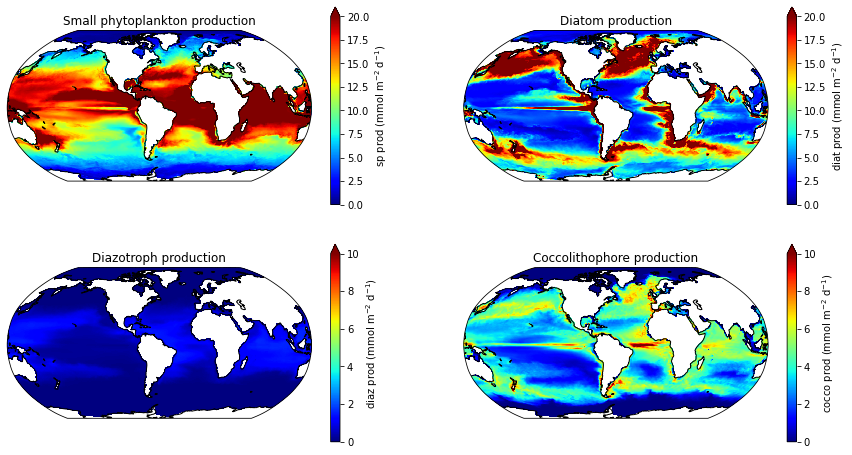

In [66]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
tmp = cesm_ann_ds2.photoC_sp_zint * 86400. #convert to mmol/m2/d
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=20,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
tmp = cesm_ann_ds2.photoC_diat_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=20,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
tmp = cesm_ann_ds2.photoC_diaz_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
tmp = cesm_ann_ds2.photoC_cocco_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)');

### Look at percent phytoC

In [67]:
phytoC = cesm_ann_ds.spC + cesm_ann_ds.diatC + cesm_ann_ds.diazC + cesm_ann_ds.coccoC
perc_sp = cesm_ann_ds.spC / (phytoC) * 100.
perc_cocco = cesm_ann_ds.coccoC / (phytoC) * 100.
perc_diat = cesm_ann_ds.diatC / (phytoC) * 100.
perc_diaz = cesm_ann_ds.diazC / (phytoC) * 100.

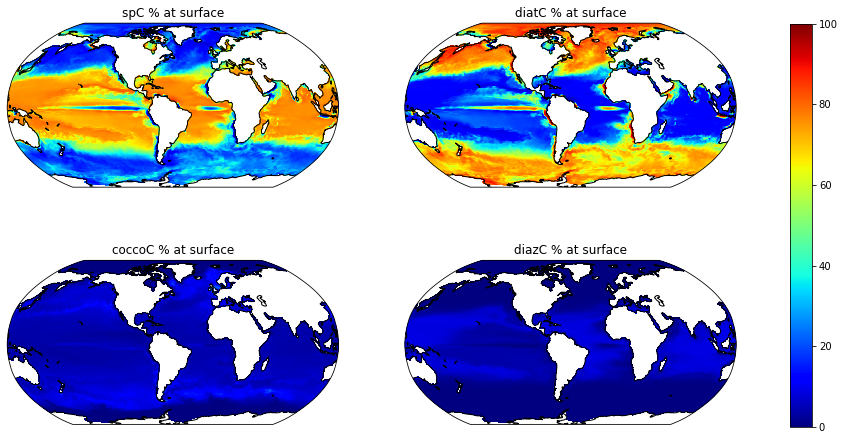

In [68]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC % at surface', fontsize=12)
field = perc_cocco.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
field = perc_diat.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
field = perc_sp.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
field = perc_diaz.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax);

### Plot zooC

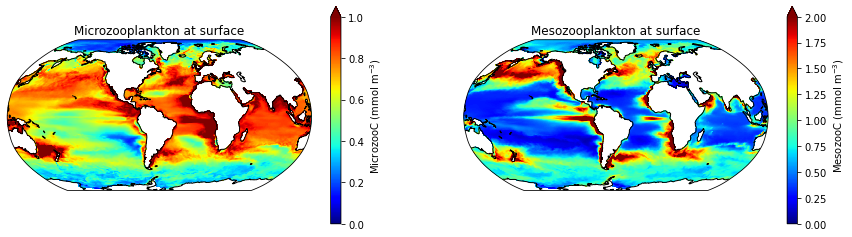

In [69]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton at surface', fontsize=12)
field = cesm_ann_ds.microzooC.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MicrozooC (mmol m$^{-3}$)')

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton at surface', fontsize=12)
field = cesm_ann_ds.mesozooC.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MesozooC (mmol m$^{-3}$)');


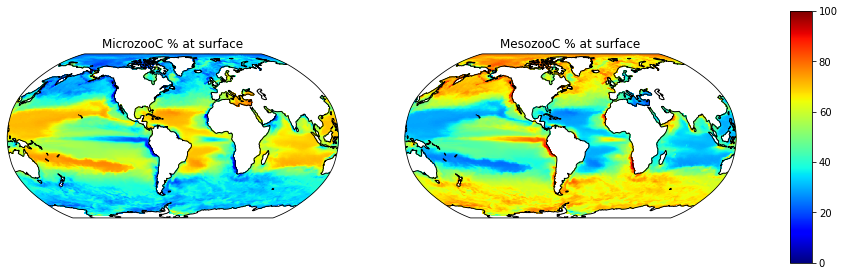

In [70]:
zooC = cesm_ann_ds.microzooC + cesm_ann_ds.mesozooC
perc_microzoo = cesm_ann_ds.microzooC / (zooC) * 100.
perc_mesozoo = cesm_ann_ds.mesozooC / (zooC) * 100.

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MicrozooC % at surface', fontsize=12)
field = perc_microzoo.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MesozooC % at surface', fontsize=12)
field = perc_mesozoo.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax);

### Zooplankton production maps

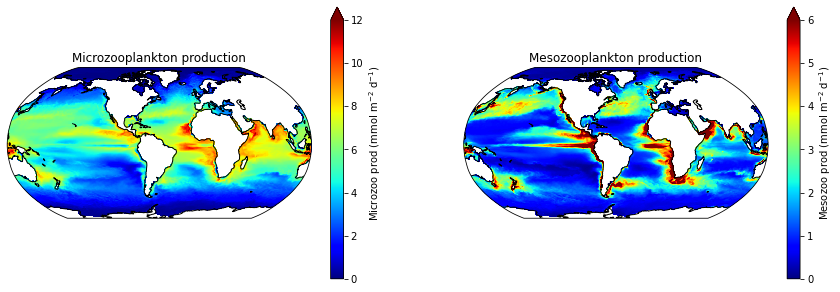

In [71]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton production', fontsize=12)
tmp = cesm_ann_ds2.x_graze_microzoo_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=12,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Microzoo prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton production', fontsize=12)
tmp = cesm_ann_ds2.x_graze_mesozoo_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=6,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mesozoo prod (mmol m$^{-2}$ d$^{-1}$)')

## NPP global maps

In [72]:
### Read in obs: VGPM and CbPM NPP algorithms

ds_vgpm_mean = xr.open_dataset('/glade/work/kristenk/obs4diag/mean_VGPM_010825.nc')
ds_cbpm_mean = xr.open_dataset('/glade/work/kristenk/obs4diag/mean_CbPM_010825.nc')
ds_cafe_mean = xr.open_dataset('/glade/u/home/junyu/work/CAFE_NPP/CAFE_NPP_MODIS_ave.nc')

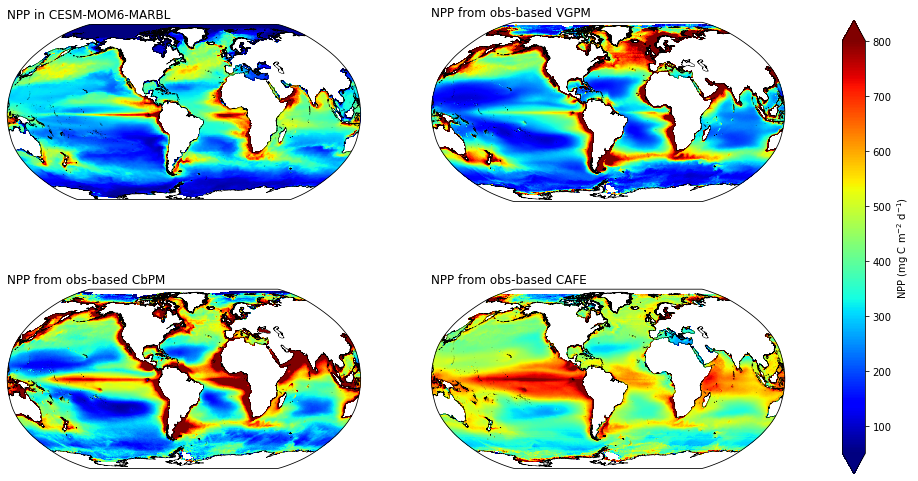

In [73]:
fig = plt.figure(figsize=(16,9))

#----------
ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP in CESM-MOM6-MARBL', loc='left')

ax.coastlines('10m',linewidth=0.5)

field = cesm_ann_ds2.photoC_TOT_zint*86400. * 12.011 ## converting to mgC/m2/d

pc=ax.pcolormesh(lons, lats, field,
                 vmin=50, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())
################################

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP from obs-based VGPM', loc='left')

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_vgpm_mean.lon, ds_vgpm_mean.lat, 
                 ds_vgpm_mean.NPP,
                 vmin=50, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

#############################

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP from obs-based CbPM', loc='left')

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_cbpm_mean.lon, ds_cbpm_mean.lat, 
                 ds_cbpm_mean.npp,
                 vmin=50, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

#############################

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP from obs-based CAFE', loc='left')

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_cafe_mean.lon, ds_cafe_mean.lat, 
                 ds_cafe_mean.CAFE_NPP_MODIS,
                 vmin=50, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='both',label='NPP (mg C m$^{-2}$ d$^{-1}$)')


## Chlorophyll comparison

In [74]:
chl_file = '/glade/work/kristenk/satellite_data/Chl_cumulative_mean/A20021852020182.L3m_CU_CHL_chlor_a_9km.nc'
ds_chl = xr.open_dataset(chl_file, decode_times=False)
#units are mg/m3
tot_chl = cesm_ann_ds.spChl.isel(z_l=0) + cesm_ann_ds.diatChl.isel(z_l=0) + cesm_ann_ds.coccoChl.isel(z_l=0) + cesm_ann_ds.diazChl.isel(z_l=0)

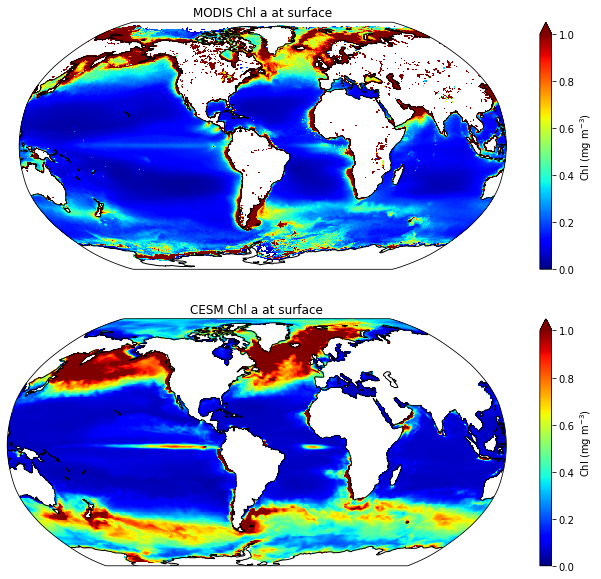

In [75]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS Chl a at surface', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(ds_chl.lon, ds_chl.lat, ds_chl.chlor_a, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl a at surface', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(lons, lats, tot_chl, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')


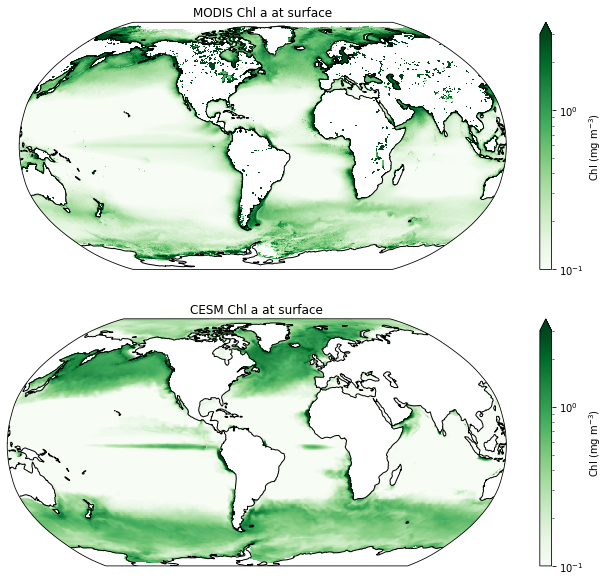

In [76]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS Chl a at surface', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(ds_chl.lon.values, ds_chl.lat.values, ds_chl.chlor_a, 
                 cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl a at surface', fontsize=12)
ax.coastlines('110m',linewidth=1)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tot_chl)
pc=ax.pcolormesh(lon, lat, field,
                 cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')


### Z-ratio (Stock & Dunne, 2010)

In [77]:
file = '/glade/work/kristenk/z-ratio/z_ratio_POPgrid2.nc'
ds_zratio = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [78]:
z_ratio = cesm_ann_ds2.x_graze_mesozoo_zint / cesm_ann_ds2.photoC_TOT_zint

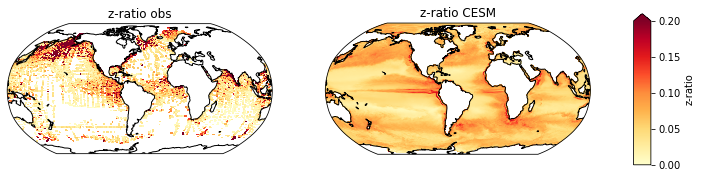

In [79]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio obs', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(ds_zratio.TLONG, ds_zratio.TLAT, ds_zratio.z_ratio)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio CESM', fontsize=12)
pc=ax.pcolormesh(lons, lats, z_ratio, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='z-ratio');

### MAREDAT Micozooplankton/zoo1+zoo2 comparison

In [80]:
file = '/glade/work/kristenk/MAREDAT/microzooplankton/mean_fields/MAREDAT_microzoo_means.nc'
maredat_microzoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

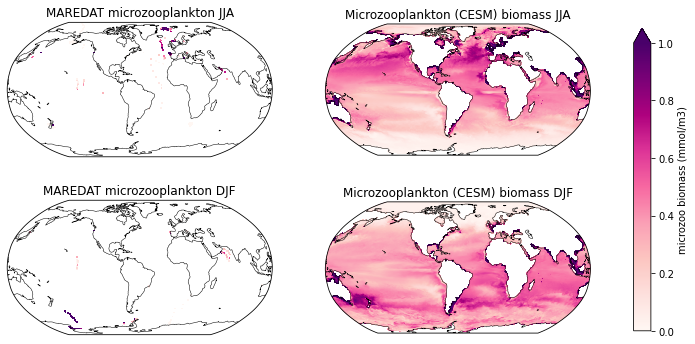

In [81]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton JJA', fontsize=12)
tmp = maredat_microzoo_ds.JJA_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (CESM) biomass JJA', fontsize=12)
tmp = cesm_mon_ds.microzooC.isel(month=[5,6,7],z_l=slice(0,10)).mean(dim='z_l').mean(dim='month')
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton DJF', fontsize=12)
tmp = maredat_microzoo_ds.DJF_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (CESM) biomass DJF', fontsize=12)
tmp = cesm_mon_ds.microzooC.isel(month=[11,0,1],z_l=slice(0,10)).mean(dim='z_l').mean(dim='month')
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max',label='microzoo biomass (mmol/m3)');

### COPEPOD comparison (Mesozooplankton)

In [82]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

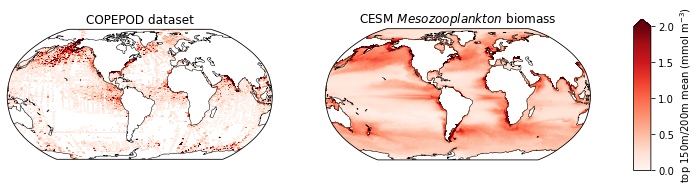

In [83]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(ds_zratio.TLONG, ds_zratio.TLAT,  ds_copepod.copepod_C)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
tmp = cesm_ann_ds.mesozooC.isel(z_l=slice(0,10)).mean(dim='z_l') #take mean just over the top 200m
pc=ax.pcolormesh(lons, lats, tmp, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)');

### compare to spatially interpolated COPEPOD climatology
#### (dataset is in units of mgC/m2, despite its being labeled otherwise, personal communication with Colleen Petrik)

In [84]:
file = '/glade/u/home/kristenk/work/copepod-biomass/obsglmm_zmeso_vint_200m_monthly_climatology.nc'
ds_copepod_clim = xr.open_dataset(file)

In [85]:
ds_copepod_clim.zmeso200.attrs['units'] = 'mgC m-2'

### depth integrate CESM and convert to same units

In [86]:
### depth integrate and convert model to mol/m2
cesm_mon_ds['mesozooC_zint'] = ((cesm_mon_ds.mesozooC) * dz).sum(dim='z_l') #in mmol/m2
cesm_mon_ds['mesozooC_zint'] = cesm_mon_ds['mesozooC_zint'] * 12.011 #convert to mgC/m2
cesm_mon_ds['mesozooC_zint'].attrs['units'] = 'mgC m-2'

In [87]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

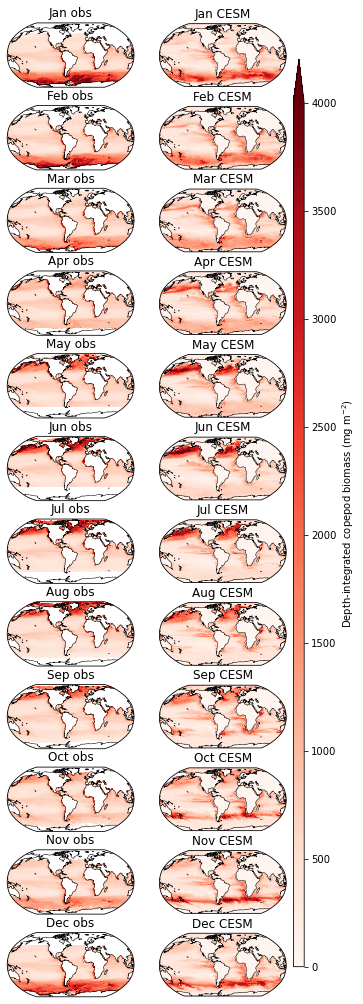

In [88]:
fig = plt.figure(figsize=(5,18))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' obs', fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), 
                     cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' CESM', fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(month=ts)
    pc=ax.pcolormesh(lons, lats, tmp, cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Depth-integrated copepod biomass (mg m$^{-2}$)');

## coccoCaCO3 and PIC from satellite

In [89]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)

#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

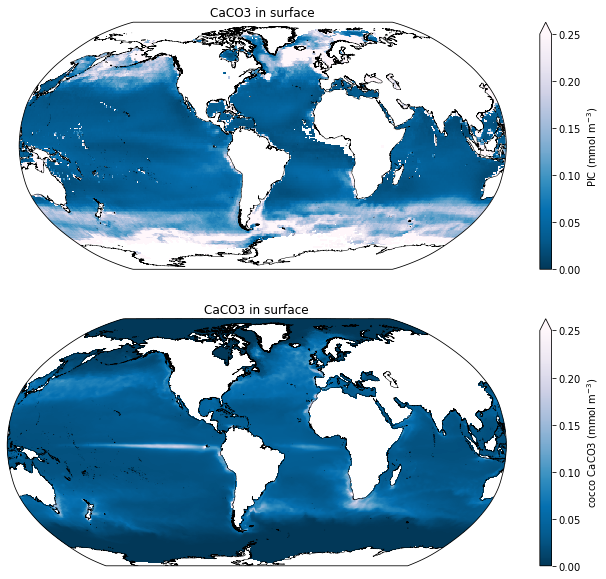

In [90]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='PIC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
field = cesm_ann_ds.coccoCaCO3.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco CaCO3 (mmol m$^{-3}$)')


### cocco PIC/POC

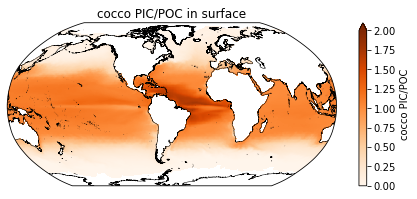

In [91]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('cocco PIC/POC in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
field = (cesm_ann_ds.coccoCaCO3.isel(z_l=0)/cesm_ann_ds.coccoC.isel(z_l=0)).where(cesm_ann_ds.coccoC.isel(z_l=0)>0.001)
pc=ax.pcolormesh(lons, lats, field, cmap='Oranges',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco PIC/POC')


## A few Antarctic views of NPP compared to "obs"

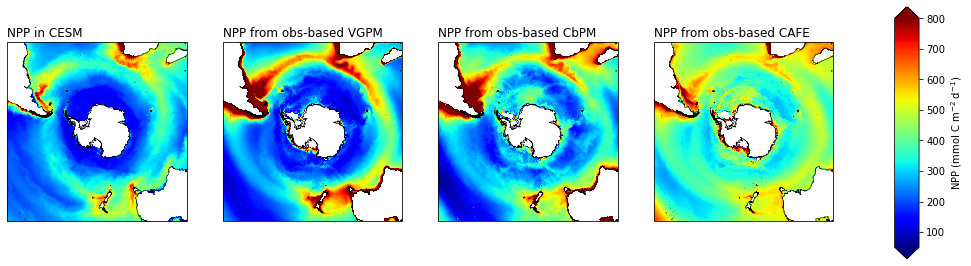

In [92]:
fig = plt.figure(figsize=(17,5))

import matplotlib.path as mpath
#----------
ax = fig.add_subplot(1,4,1, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP in CESM', loc='left')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
field = cesm_ann_ds2.photoC_TOT_zint*86400.

pc=ax.pcolormesh(lons, lats, field,
                 vmin=0, vmax=70, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


ax = fig.add_subplot(1,4,2, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP from obs-based VGPM', loc='left')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_vgpm_mean.lon, ds_vgpm_mean.lat, 
                 ds_vgpm_mean.NPP,
                 vmin=50, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

#############################

ax = fig.add_subplot(1,4,3, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP from obs-based CbPM', loc='left')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_cbpm_mean.lon, ds_cbpm_mean.lat, 
                 ds_cbpm_mean.npp,
                 vmin=50, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


ax = fig.add_subplot(1,4,4, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP from obs-based CAFE', loc='left')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_cafe_mean.lon, ds_cafe_mean.lat, 
                 ds_cafe_mean.CAFE_NPP_MODIS,
                 vmin=50, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='both',label='NPP (mmol C m$^{-2}$ d$^{-1}$)')


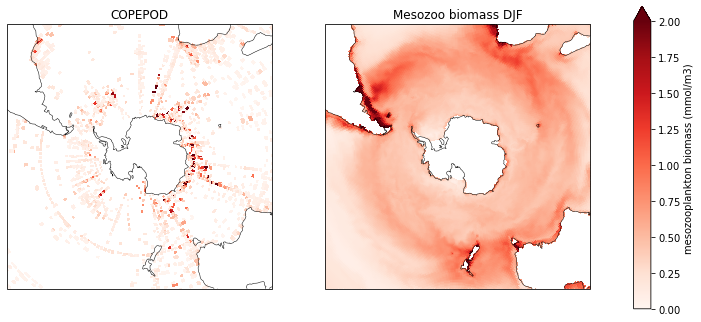

In [93]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('COPEPOD')
lon, lat, field = utils.adjust_pop_grid(ds_zratio.TLONG, ds_zratio.TLAT, ds_copepod.copepod_C)
pc=ax.pcolormesh(lon, lat, field, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################

ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('Mesozoo biomass DJF', fontsize=12)
tmp = cesm_ann_ds.mesozooC.isel(z_l=slice(0,10)).mean(dim='z_l') #take mean just over the top 200m
pc=ax.pcolormesh(lons, lats, tmp, 
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())


ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='mesozooplankton biomass (mmol/m3)');

## N fixation map

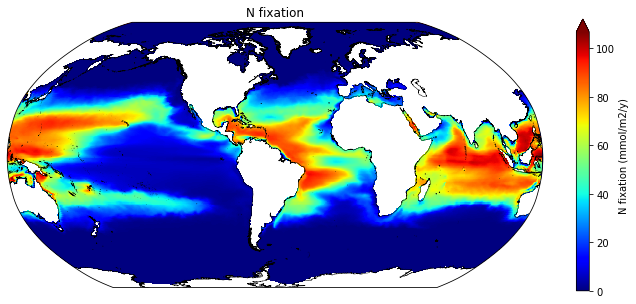

In [94]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('N fixation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
field = (cesm_ann_ds['diaz_Nfix']*dz).sum(dim='z_l').where(ds_grid.wet==1) * 86400. * 365.
pc=ax.pcolormesh(lons, lats, field, cmap='jet',
                 #vmin=0,vmax=2,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='N fixation (mmol/m2/y)')


## Alkalinity

In [95]:
### Salinity normalized ALK
ds_glodap['sAlk'] = ds_glodap.TAlk/ds_glodap.salinity * 35.

In [96]:
cesm_ann_ds['sAlk'] = cesm_ann_ds.ALK/cesm_ann_ds.so * 35.

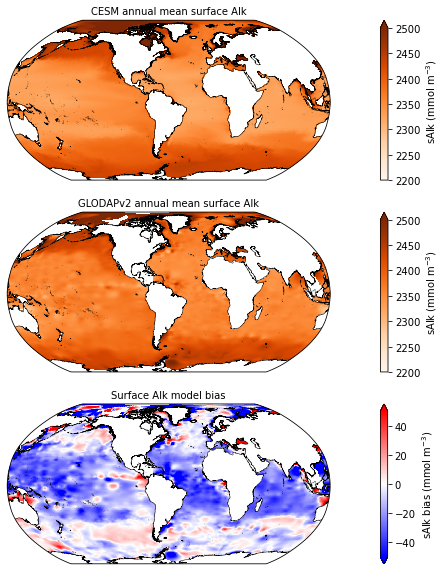

In [97]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))

# #---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface Alk', fontsize=10)
pc1=ax.pcolormesh(lons, lats,  cesm_ann_ds.sAlk.isel(z_l=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('GLODAPv2 annual mean surface Alk', fontsize=10)
pc2=ax.pcolormesh(lons, lats, ds_glodap.sAlk.isel(z_l=0),
                  cmap='Oranges', vmin=2200, vmax=2500, transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- DIFF panel
sALK_diff = cesm_ann_ds.sAlk - (ds_glodap.sAlk)

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface Alk model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats,  sALK_diff.isel(z_l=0),
                  vmin=-50, vmax=50, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='sAlk bias (mmol m$^{-3}$)')

### Export ratio

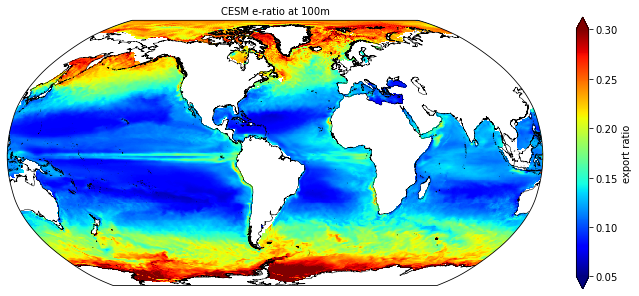

In [98]:
#plot E-RATIO
eratio = cesm_ann_ds2.POC_FLUX_100m/cesm_ann_ds2.photoC_TOT_zint

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM e-ratio at 100m', fontsize=10)
field = eratio
pc1=ax.pcolormesh(lons, lats, 
                 field, cmap='jet',
                  vmin=0.05, vmax=0.3, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='export ratio')


## Iron distributions

In [99]:
dFe_obs_file = '/glade/u/home/kristenk/cesm2-marbl/notebooks/discrete_obs/dFe-database-2021-05-20.csv'
df = pd.read_csv(dFe_obs_file, na_values=-999.).dropna(axis=0, how='all')
df

lon      lat   depth   dFe_obs
0      210.010 -16.0018    20.0  0.540000
1      210.010 -16.0018    35.0  0.440000
2      210.010 -16.0019    50.0  0.480000
3      210.010 -16.0019    80.0  0.400000
4      210.010 -16.0020   100.0  0.390000
...        ...      ...     ...       ...
27777  160.051  47.0032  3929.6  0.825681
27778  160.051  47.0032  3929.8  0.902248
27779  160.051  47.0032  4900.4  0.555630
27780  160.051  47.0032  4900.9  0.621851
27781  160.051  47.0032  5210.1  0.573220

[27782 rows x 4 columns]

In [100]:
### Make averages of Fe concentrations within depth layers

Fe_top112m = (((cesm_ann_ds['Fe'] * dz).isel(z_l=slice(0,7)).sum(dim='z_l'))/dz.isel(z_l=slice(0,7)).sum(dim='z_l')).where(ds_grid.wet>0)

Fe_112m_550m = (((cesm_ann_ds['Fe'] * dz).isel(z_l=slice(7,14)).sum(dim='z_l'))/dz.isel(z_l=slice(7,14)).sum(dim='z_l')).where(ds_grid.wet>0)

Fe_gt_550m = (((cesm_ann_ds['Fe'] * dz).isel(z_l=slice(14,34)).sum(dim='z_l'))/dz.isel(z_l=slice(14,34)).sum(dim='z_l')).where(ds_grid.wet>0)

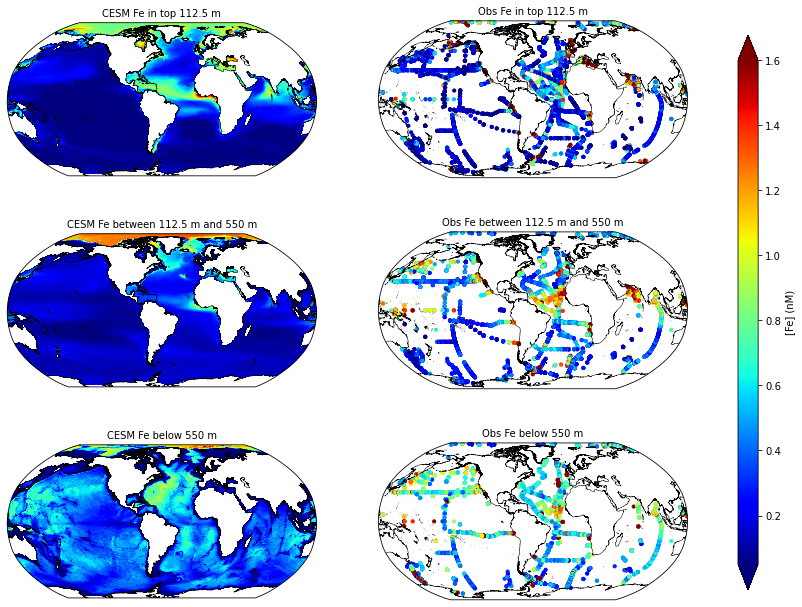

In [101]:
fig = plt.figure(figsize=(14,11))

mmolm3_to_nM = 1e3

### CESM
ax = fig.add_subplot(3,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM Fe in top 112.5 m', fontsize=10)

pc1=ax.pcolormesh(lons, lats, 
                 Fe_top112m*mmolm3_to_nM, cmap='jet',
                  vmin=0.05, vmax=1.6, 
                 transform=ccrs.PlateCarree())

# ### obs
ax = fig.add_subplot(3,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Obs Fe in top 112.5 m', fontsize=10)

df_sub = df.loc[(df.depth <= 112.5)]
sc = ax.scatter(df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap='jet',
                vmin=0.05, vmax=1.6, s=10,
                transform=ccrs.PlateCarree())

#############################################
### CESM
ax = fig.add_subplot(3,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM Fe between 112.5 m and 550 m', fontsize=10)

pc1=ax.pcolormesh(lons, lats, 
                 Fe_112m_550m*mmolm3_to_nM, cmap='jet',
                  vmin=0.05, vmax=1.6, 
                 transform=ccrs.PlateCarree())

# ### obs
ax = fig.add_subplot(3,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Obs Fe between 112.5 m and 550 m', fontsize=10)


df_sub = df[(df.depth > 112.5) & (df.depth <= 550)]
sc = ax.scatter(df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap='jet',
                vmin=0.05, vmax=1.6, s=10,
                transform=ccrs.PlateCarree())


#############################################
### CESM
ax = fig.add_subplot(3,2,5, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM Fe below 550 m', fontsize=10)

pc1=ax.pcolormesh(lons, lats, 
                 Fe_gt_550m*mmolm3_to_nM, cmap='jet',
                  vmin=0.05, vmax=1.6, 
                 transform=ccrs.PlateCarree())

# ### obs
ax = fig.add_subplot(3,2,6, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Obs Fe below 550 m', fontsize=10)


df_sub = df[(df.depth > 550)]
sc = ax.scatter(df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap='jet',
                vmin=0.05, vmax=1.6, s=10,
                transform=ccrs.PlateCarree())


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='[Fe] (nM)')

### Plot iron at surface (above 5m)

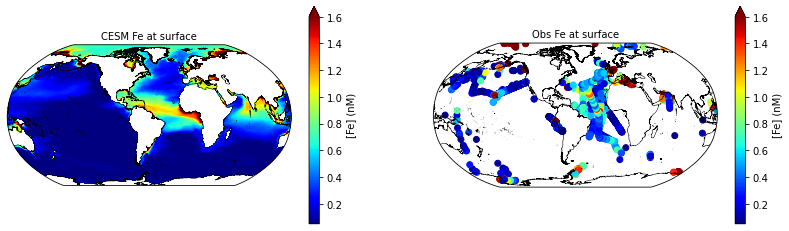

In [102]:
fig = plt.figure(figsize=(14,4))

mmolm3_to_nM = 1e3

### CESM
ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM Fe at surface', fontsize=10)

field = cesm_ann_ds['Fe'].isel(z_l=0)
pc1=ax.pcolormesh(lons, lats, 
                 field*mmolm3_to_nM, cmap='jet',
                  vmin=0.05, vmax=1.6, 
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='[Fe] (nM)')

### obs
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Obs Fe at surface', fontsize=10)


df_sub = df.loc[(df.depth <= 5)]
sc = ax.scatter(df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap='jet',
                vmin=0.05, vmax=1.6, 
                transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(sc, ax=ax,extend='max',label='[Fe] (nM)')

In [103]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
